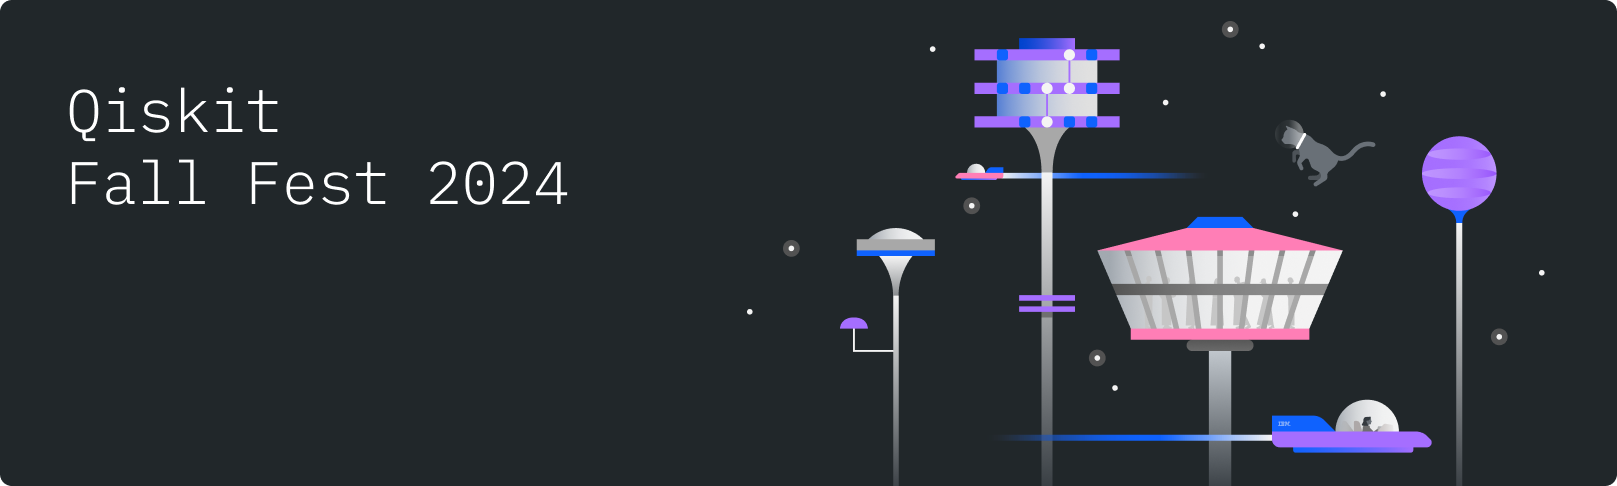

# Graded Notebook 3: The Transpiler

*   Difficulty: 3/5
*   Estimated Time: 75 minutes

# Welcome to the Qiskit Fall Fest! <a name="welcome"></a>

Hi there and welcome to the **Qiskit Fall Fest**!

Whether you're a total beginner or a PhD candidate in quantum physics, there is something here for you. Thanks for joining us.  😀

As part of the Qiskit Fall Fest, IBM Quantum has created a series of notebooks for you to work through, which all include coding challenges and Qiskit tutorials. Each notebook has a difficulty and an estimated time, which you can find at the top.

The Qiskit Fall Fest is a massive event, featuring thousands of students worldwide who are all learning about quantum computing and Qiskit. Just by being here, you're helping to make history. Your participation is helping to shape what the future of the industry will look like. Congratulations and welcome!

---

Each of these notebooks builds upon the previous learning. This first one is meant for anyone to complete, even beginners, but later notebooks are more difficult. Most participants will need to do some outside research or use a bit of trial-and-error to finish the code challenges presented in the more advanced notebooks. Don't give up! We know you can do it.

In each notebook, you will find links to documentation, tutorials, and other helpful resources you might need to solve that particular problem. You can also find most of these resources on IBM's new home for quantum education: [IBM Quantum Learning](https://learning.quantum.ibm.com/).

# Table of contents

* [Prologue - What is the transpiler?](#prologue)   
* [Transpile with Preset Pass Managers](#preset_passmanager)    
* [Optimization levels](#optimization_level)
    * [Optimization level = 0](#opt_lv_0)
    * [Optimization level = 1](#opt_lv_1)
    * [Optimization level = 2](#opt_lv_2)
    * [Optimization level = 3](#opt_lv_3)
* [Transpiler Stage Details with Options](#transpiler_options)
    * [Init stage](#init)
    * [Layout Stage](#layout)
    * [Routing Stage](#routing)
    * [Translation Stage](#translation)
* [(Bonus) Ecosystem and Qiskit Transpiler Plugin](#plugin)  

<a id='toc2_'></a>
<a name='toc2_'></a>

# Setup

Let's begin by getting all the necessary installs and imports out of the way.

If you are running things locally, you may already have these installed from a previous notebook. If you're running in the cloud, you may need to re-install for each notebook.

In [1]:
### Install Qiskit and relevant packages, if needed

%pip install qiskit[visualization]
%pip install qiskit_ibm_runtime
%pip install qiskit_aer
%pip install qiskit-transpiler-service
%pip install graphviz
%pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to c:\users\aurob\appdata\local\temp\pip-req-build-rht2a7zh
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 49b232a1e821722e6820d54fdcb2d1117a75f597
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git 'C:\Users\aurob\AppData\Local\Temp\pip-req-build-rht2a7zh'


And now, save your IBM Quantum API token to use the runtime primitives. You can skip this if you have already saved your token to the runtime.

In [2]:
### Save API Token, if needed

%set_env QXToken=8884c7e1645b2faee4865ee3d2d42a633973f09ce772128b2bcc0cebf27bf3e2add50dacb89e2237938f92b2f652c32de47614446e7b0c6193d3996700198764


# Make sure there is no space between the equal sign
# and the beginning of your token

env: QXToken=8884c7e1645b2faee4865ee3d2d42a633973f09ce772128b2bcc0cebf27bf3e2add50dacb89e2237938f92b2f652c32de47614446e7b0c6193d3996700198764


Finally, let's run our imports and setup the grader

In [3]:
# Imports

from qiskit.circuit.random import random_circuit
from qiskit.circuit.library import XGate, YGate
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeOsaka
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler import InstructionProperties, PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins
from qiskit.visualization import plot_circuit_layout

import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Setup the grader
from qc_grader.challenges.fall_fest24 import (
    grade_lab3_ex1,
    grade_lab3_ex2,
    grade_lab3_ex3,
    grade_lab3_metaphors
)

# Prologue - What is the transpiler?<a name="prologue"></a>

Let's start with a hypothetical question:

When someone hands you their car keys and says "will you fill my car up with fuel?" - how do you know what to do?

Sure, you have your driver's license, but what type of car do they have? Where is their gear shifter? How do you turn on the blinker to turn the corner, or open the fuel tank once your arrive? What if it's an electric car that doesn't even *have* a fuel tank??

Luckily, the human brain is smart. It is able to take a set of instructions and adapt them to the vehicle being used.

That, in essence, is the transpiler.

Transpilation is the process of taking a given input circuit and rewriting it to an equivalent circuit for a specific quantum device, and/or to optimize the circuit for execution on a real quantum system.

This is necessary because not all quantum devices work the same way. The instructions you send to one device might not be compatible with a different quantum backend. Transpilation operates in terms of a device's basis gate set, the topology of the quantum chips, timing constraints, and more which we will explore in this notebook.

The goal of a transpiler is to get the best performance from noisy quantum hardware. Most circuits must undergo a series of transformations that make them compatible with a given target device, and optimize them to reduce the effects of noise on the resulting outcomes.

**For example:** the process of transpilation can take a simple looking circuit that contains your instructions:

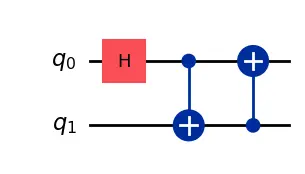

And transform it to provide the circuit you want, but by only using the basis gates or instructions that a given quantum computer is able to accept. It also will optimize those instructions in order to minimize the effects of noise:

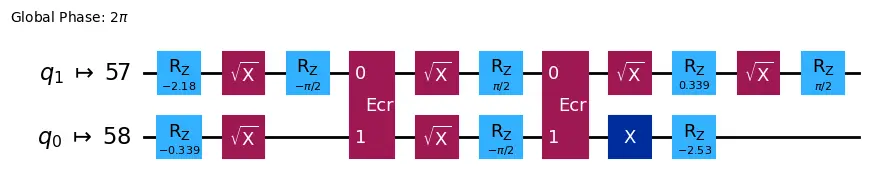

A central component of the Qiskit SDK, the transpiler is designed for modularity and extensibility. Its main goal is to write new circuit transformations (known as transpiler passes), and combine them with other existing passes, greatly reducing the depth and complexity of quantum circuits. Which passes are chained together and in which order has a major effect on the final outcome. This pipeline is determined by the [PassManager](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.PassManager) and [StagedPassManager](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.StagedPassManager) objects.

The `StagedPassManager` orchestrates the execution of one or more `PassManagers` and determines the order in which they are executed, while the `PassManager` object is merely a collection of one or more passes. Think of the `StagedPassManager` as the conductor in an orchestra, the `PassManagers` as the different instrument sections, and the `Pass` objects as the individual musicians.

In this way, you can compose hardware-efficient quantum circuits that let you execute utility-scale work while keeping noise manageable.  For more details, visit the [Transpile](https://docs.quantum.ibm.com/transpile) section in the IBM Quantum Platform docs.

## The six stages

Rewriting quantum circuits to match hardware constraints and optimizing for performance can be far from trivial. Qiskit provides users the standard six stages of compilation flows with four pre-built transpilation pipelines. By default, the preset pass managers are composed of six stages, with several options in each stages:



- `Init`: This pass runs any initial passes that are required before we start embedding the circuit to the system. This typically involves unrolling custom instructions and converting the circuit to all single- and two-qubit gates. (By default this will just validate the circuit instructions and translate multi-qubit gates into single- and two-qubit gates.)
  
- `Layout`: This stage applies a layout, mapping the virtual qubits in the circuit to the physical qubits on a backend.

- `Routing`: This stage runs after a layout has been applied and will inject gates (i.e. swaps) into the original circuit to make it compatible with the backend’s connectivity.
  
- `Translation`: This stage translates the gates in the circuit to the target backend’s basis set.
- `Optimization`: This stage runs the main optimization loop repeatedly until a condition (such as fixed depth) is reached.
- `Scheduling`: This stage is for any hardware-aware scheduling passes.


Qiskit also provides four pre-defined levels of transpilation that users can choose according to their needs. You can modify these preset pass managers, and in addition, you can construct a pass manager to build an entirely custom pipeline for transforming input circuits.

For most users who are not familiar with quantum circuit optimization by transpiling, we suggest to use one of the ready-made routines. However in this notebook we will be diving deep (deeeeeeeep!) into each stage and the options within.

<div class="alert alert-block alert-success">
<a id='ex1'></a>
<a name='ex1'></a>

### Exercise 1:

**Your Task:** Please match the description of what happens in each stage with the corresponding transpilation stage name in the code cell below.

- **A.** This stage centers around reducing the number of circuit operations and the depth of circuits with several optimization options.
- **B.** This stage inserts the appropriate number of SWAP gates in order to execute the circuits using the selected layout.
- **C.** this stage is used to translate any gates that operate on more than two qubits, into gates that only operate on one or two qubits.
- **D.** This stage executes a sequence of gates, a one-to-one mapping from the "virtual" qubits to the "physical" qubits in an actual quantum device.
- **E.** this pass can be thought of as explicitly inserting hardware-aware operations like delay instructions to account for the idle time between gate executions.
- **F.** This stage translates the gates specified in a circuit to the native basis gates of a specified backend.

<b>HINT: </b> The answer will always be a single capital letter with quotation marks. For example: "A"

</div>

In [5]:
ans = {}

# Place the correct letter next to the corresponding stage, inside a parenthesis
# example:  ans["test"] = "M"

ans["init"] = 'C'
ans["layout"] = 'D'
ans["routing"] = 'B'
ans["translation"] = 'F'
ans["optimization"] = 'A'
ans["scheduling"] = 'E'

In [6]:
# Submit your answer using following code

grade_lab3_ex1(ans)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


Good work checking your understanding on each transpiling stage. Next let's see how to use Qiskit's six transpile stages with `preset_pass_managers`.

<a name='preset_passmanager'></a>

# Transpile with preset pass managers

In this part, we will explore how to use Qiskit's standard six transpiler stages. We will focus first on the four pre-defined transpile pipelines, and see how to build your own PassManager through a practice that uses the features and options of each pass with a pre-defined pipeline.

First, let's look at what Passmanager and `generate_preset_pass_manager` are. This part and later parts refers frequently to the [IBM Quantum Platform docs](https://docs.quantum.ibm.com/transpile) and the [API reference documentation](https://docs.quantum.ibm.com/api/qiskit/transpiler) on the transpiler, so we recommend you look at them together.

## What is a (staged) pass manager?

A pass manager is an object that stores a list of transpiler passes and can execute them on a circuit. You can create a pass manager by initializing a [PassManager](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.PassManager) with a list of transpiler passes. To run the transpilation on a circuit, call the [run](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.PassManager#run) method with a circuit as input.

A staged pass manager, represented by the [`StagedPassManager`](https://docs.quantum.ibm.com/transpile/transpiler-stages) class, is a special kind of pass manager that represents a level of abstraction above that of a normal pass manager. While a normal pass manager is composed of several transpiler passes, a staged pass manager is composed of several pass managers. This is a useful abstraction because transpilation typically happens in discrete stages, with each stage being represented by a pass manager.


## `Preset Passmanagers`

Preset Passmanagers (`qiskit.transpiler.preset_passmanagers`) contains functions for generating the preset pass managers for transpiling. The preset pass managers are instances of StagedPassManager, which are used to execute the circuit transformations at the different optimization levels in the pre-defined transpiling pipeline. Here we introduce the functions used to generate the entire pass manager by using `generate_preset_pass_manager`.

<div class="alert alert-block alert-success">

## Exercise - Metaphors

It's easy to get lost in the terminology here, so think back to our metaphor about an orchestra conductor, sections, and individual musicians.

**Bonus Exercise:** Come up with your own metaphor for the relationship between a `StagedPassManager`, a `PassManager`, and a `pass`.  
Please submit your ideas to the grader! It will tell you how to share your metaphors with another Qiskit Fall Fest 2024 colleagues!
</div>

In [7]:
# Submit your answer using following code

ans = "imagine staged pass manager as a leader that ensures coherence in a team, pass manager as a individual in a team do a certain task known as pass."
grade_lab3_metaphors(ans)

Grading your answer. Please wait...
Thank you for sharing your nice ideas!How about share your ideas with another fall fest folks by visiting http://redd.it/1ezh3fs ?


## `generate_preset_pass_manager`

In Qiskit, `generate_preset_pass_manager` is used to quickly generate a preset pass manager. This function provides a convenient and simple method to construct a standalone `PassManager` object with **optimization** levels and options for each pass. Let's explore those next.

# Optimization levels <a name='optimization_level'></a>

The `generate_preset_pass_manager` function has one required positional argument, optimization_level, that controls how much effort the transpiler spends on optimizing circuits. This argument is an integer taking one of the values 0, 1, 2, or 3.

Higher optimization levels generate more optimized circuits at the expense of longer compile times, and vice versa.

<div class="alert alert-block alert-success">
<a id='ex2'></a>
<a name='ex2'></a>

### Utility function

Since the goal of transpiling is to improve the actual execution performance of the circuit, here we provide you a function that measures the performance of the translated circuit. You will use this function later in this notebook.

**Function description:** The function `scoring` should receives the transpiled circuit, its *[final layout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.TranspileLayout#final_layout)*, and its target backend as its inputs. The function should then return a circuit score. The closer the score is to 0, the better.

Other notes:
* Please use `FakeTorino` from the `qiskit-ibm-runtime` package for this whole lab.
* The algorithm for calculating the actual score is from [Mapomatic](https://github.com/qiskit-community/mapomatic), and the main code has been updated to suit PrimitiveV2.
* You will need to get the final layout of transpiled circuit. These two pages should help you complete the code below to finish the function.
  * [The layout section from the QuantumCircuit API documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#layout)
  * [The TranspileLayout section from the Qiskit Transpiler API documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.TranspileLayout)
</div>

In [8]:
def scoring(qc, backend):
    gate_count = qc.count_ops()
    if "cz" not in gate_count:
        gate_count["cz"] = 0

    score = gate_count['cz'] * 10
    score += gate_count.get('sx', 0) * 1
    score += gate_count.get('rz', 0) * 1
    return score

Now you have a function to measure the performance of a transpiled circuit. Before we move on to the next part, let's finish setting up everything we need to properly test our circuit on a fake backend.

Namely, a circuit, and a fake backend!

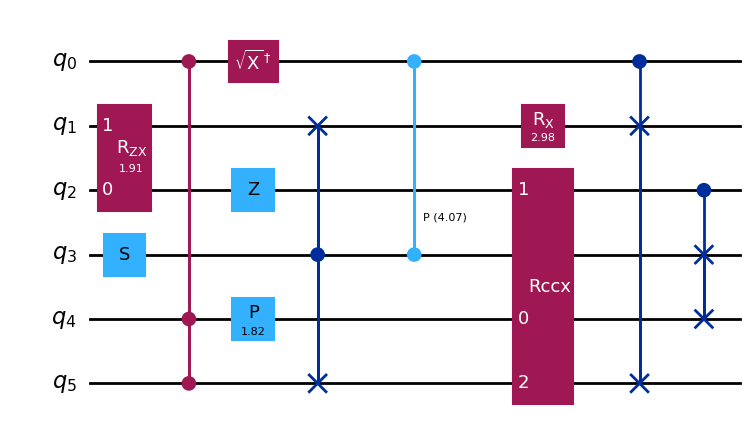

In [9]:
### Create a random circuit

## DO NOT CHANGE THE SEED NUMBER
seed = 10000

## Create circuit

num_qubits = 6
depth = 4
qc = random_circuit(num_qubits,depth,measure=False, seed=seed)

qc.draw('mpl')

<div class="alert alert-block alert-warning">

<b>Be careful!</b>
    
To pass the grader, do not change the seed values for `seed` or `seed_transpiler` throughout this entire notebook.
</div>

To test the performance of each optimization level, call `FakeTorino` and save it as `backend`.

`FakeTorino` has the connectivity and noise features of ibm_torino, which is the latest IBM Quantum backend with a Heron processor.

In [10]:
## Save FakeTorino as backend

backend = FakeTorino()

We are going to walk through running all four optimization levels and then compare our results at the end. In order to do this, we will create a few arrays to hold the information as we work, then use them later on.

In the next code cell, we're simply constructing these arrays. You can run it and move on for now.

In [11]:
circuit_depths = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}
gate_counts = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}

scores = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}

## Optimization level = 0 <a name='opt_lv_0'></a>

<div class="alert alert-block alert-info">

If at any point during these four sections you need help or clarification, please refer to <a href="https://docs.quantum.ibm.com/transpile/set-optimization">this documentation</a> for a better understanding of optimization_level.

</div>

Optimization level 0 is intended for **device characterization experiments** and, as such, only maps the input circuit to the constraints of the target backend without performing any optimizations. It performs layout/routing with [TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout), where it selects the same physical qubit numbers as virtual and inserts SWAPs to make it work (using [StochasticSwap](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.StochasticSwap#stochasticswap)).

Let's make a pass manager with optimization level = 0 using our FakeTorino backend and see the result.

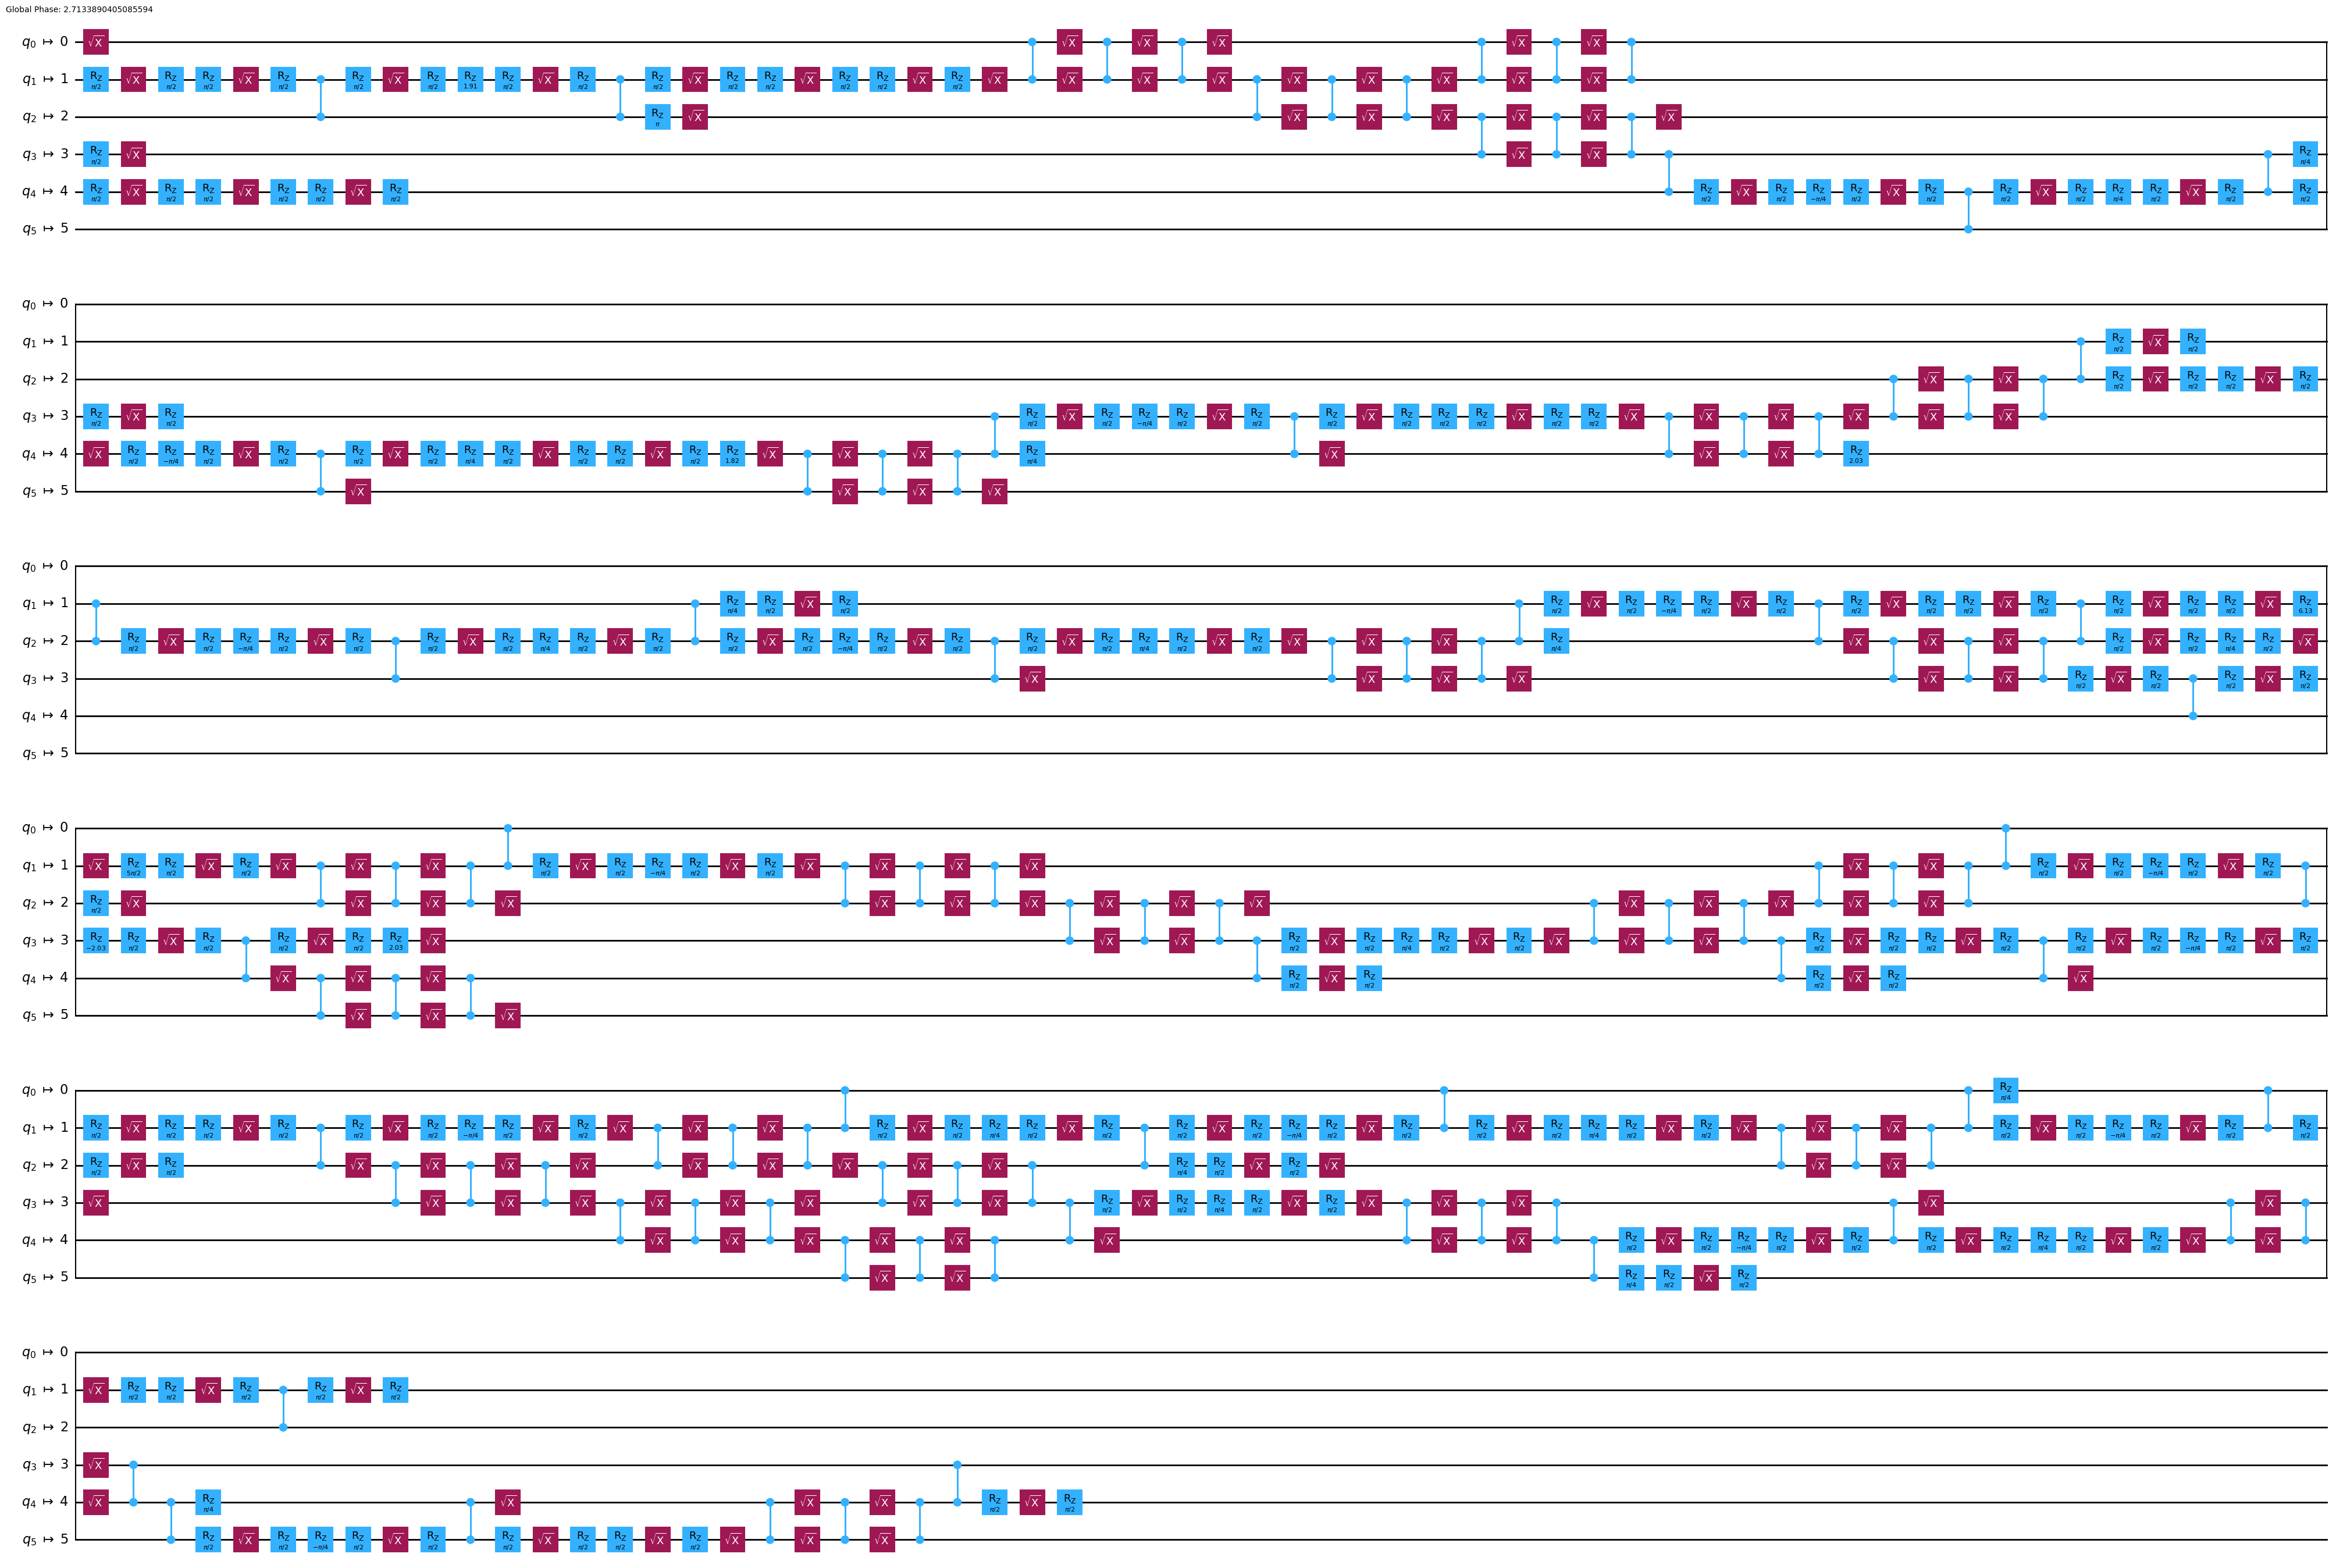

In [12]:
# Make a pass manager with our desired optimization level and backend
pm_lv0 = generate_preset_pass_manager(backend=backend, optimization_level=0, seed_transpiler=seed)

# Run for our random circuit
tr_lv0 = pm_lv0.run(qc)

# uncomment the next line to draw circuit
tr_lv0.draw('mpl', idle_wires=False, fold=60)

As mentioned previously, optimization_level=0 is performing a basic gate decomposition by using basis gates of the backend and mapping logical qubits to physical qubits with a same order of number. It maps logical qubit 0 to physical qubit 0 and maps logical qubit 1 to physical qubit 1.

<div class="alert alert-block alert-success">
<a id='ex3'></a>
<a name='ex3'></a>

### Exercise 2: (Start)

**Your Task:** Find the circuit depth of the random circuit, the sum of the total gate number, and compute the performance score of this circuit using `scoring`. Use the provided code to save each of these results to our previously made array.

</div>

<div class="alert alert-block alert-info">

Tips:
- for the `circuit_depths`: [IBM Documentation](https://docs.quantum.ibm.com/api/qiskit/0.42/circuit)
- for the `gate_counts`: We sometimes says the "size" of circuit is a total number of instructions: [Size](https://docs.quantum.ibm.com/api/qiskit/0.42/qiskit.circuit.QuantumCircuit#size)
- for the `scores`: Use the `scoring` function you previously made

</div>

In [13]:
### Your code here ###

circuit_depths['opt_lv_0'] = tr_lv0.depth()
gate_counts['opt_lv_0'] = tr_lv0.size()
scores['opt_lv_0'] = scoring(tr_lv0, backend)

### Don't change code after this line ###

print("Optimization level 0 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_0'])
print("Gate count:", gate_counts['opt_lv_0'])
print("Score:", scores['opt_lv_0'])

Optimization level 0 results
Circuit depth: 327
Gate count: 566
Score: 1547




## Optimization level = 1 <a name='opt_lv_1'></a>

Optimization level 1 performs a **`light optimization`**. Here's what that means:

- Layout/Routing: Layout is first attempted with [TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout). If additional SWAPs are required, a layout with a minimum number of SWAPs is found by using [SabreSWAP](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.SabreSwap#sabreswap), then it uses [VF2LayoutPostLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.VF2PostLayout)` to try to select the best qubits in the graph.
- [InverseCancellation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.InverseCancellation#inversecancellation)
- [1Q gate optimization](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.Optimize1qGates#optimize1qgates)

Try making a pass manager on your own this time. Once again use the FakeTorino backend with `generate_preset_pass_manager`. Please also set the `optimization_level` to 1, and `seed_transpiler` = `seed`

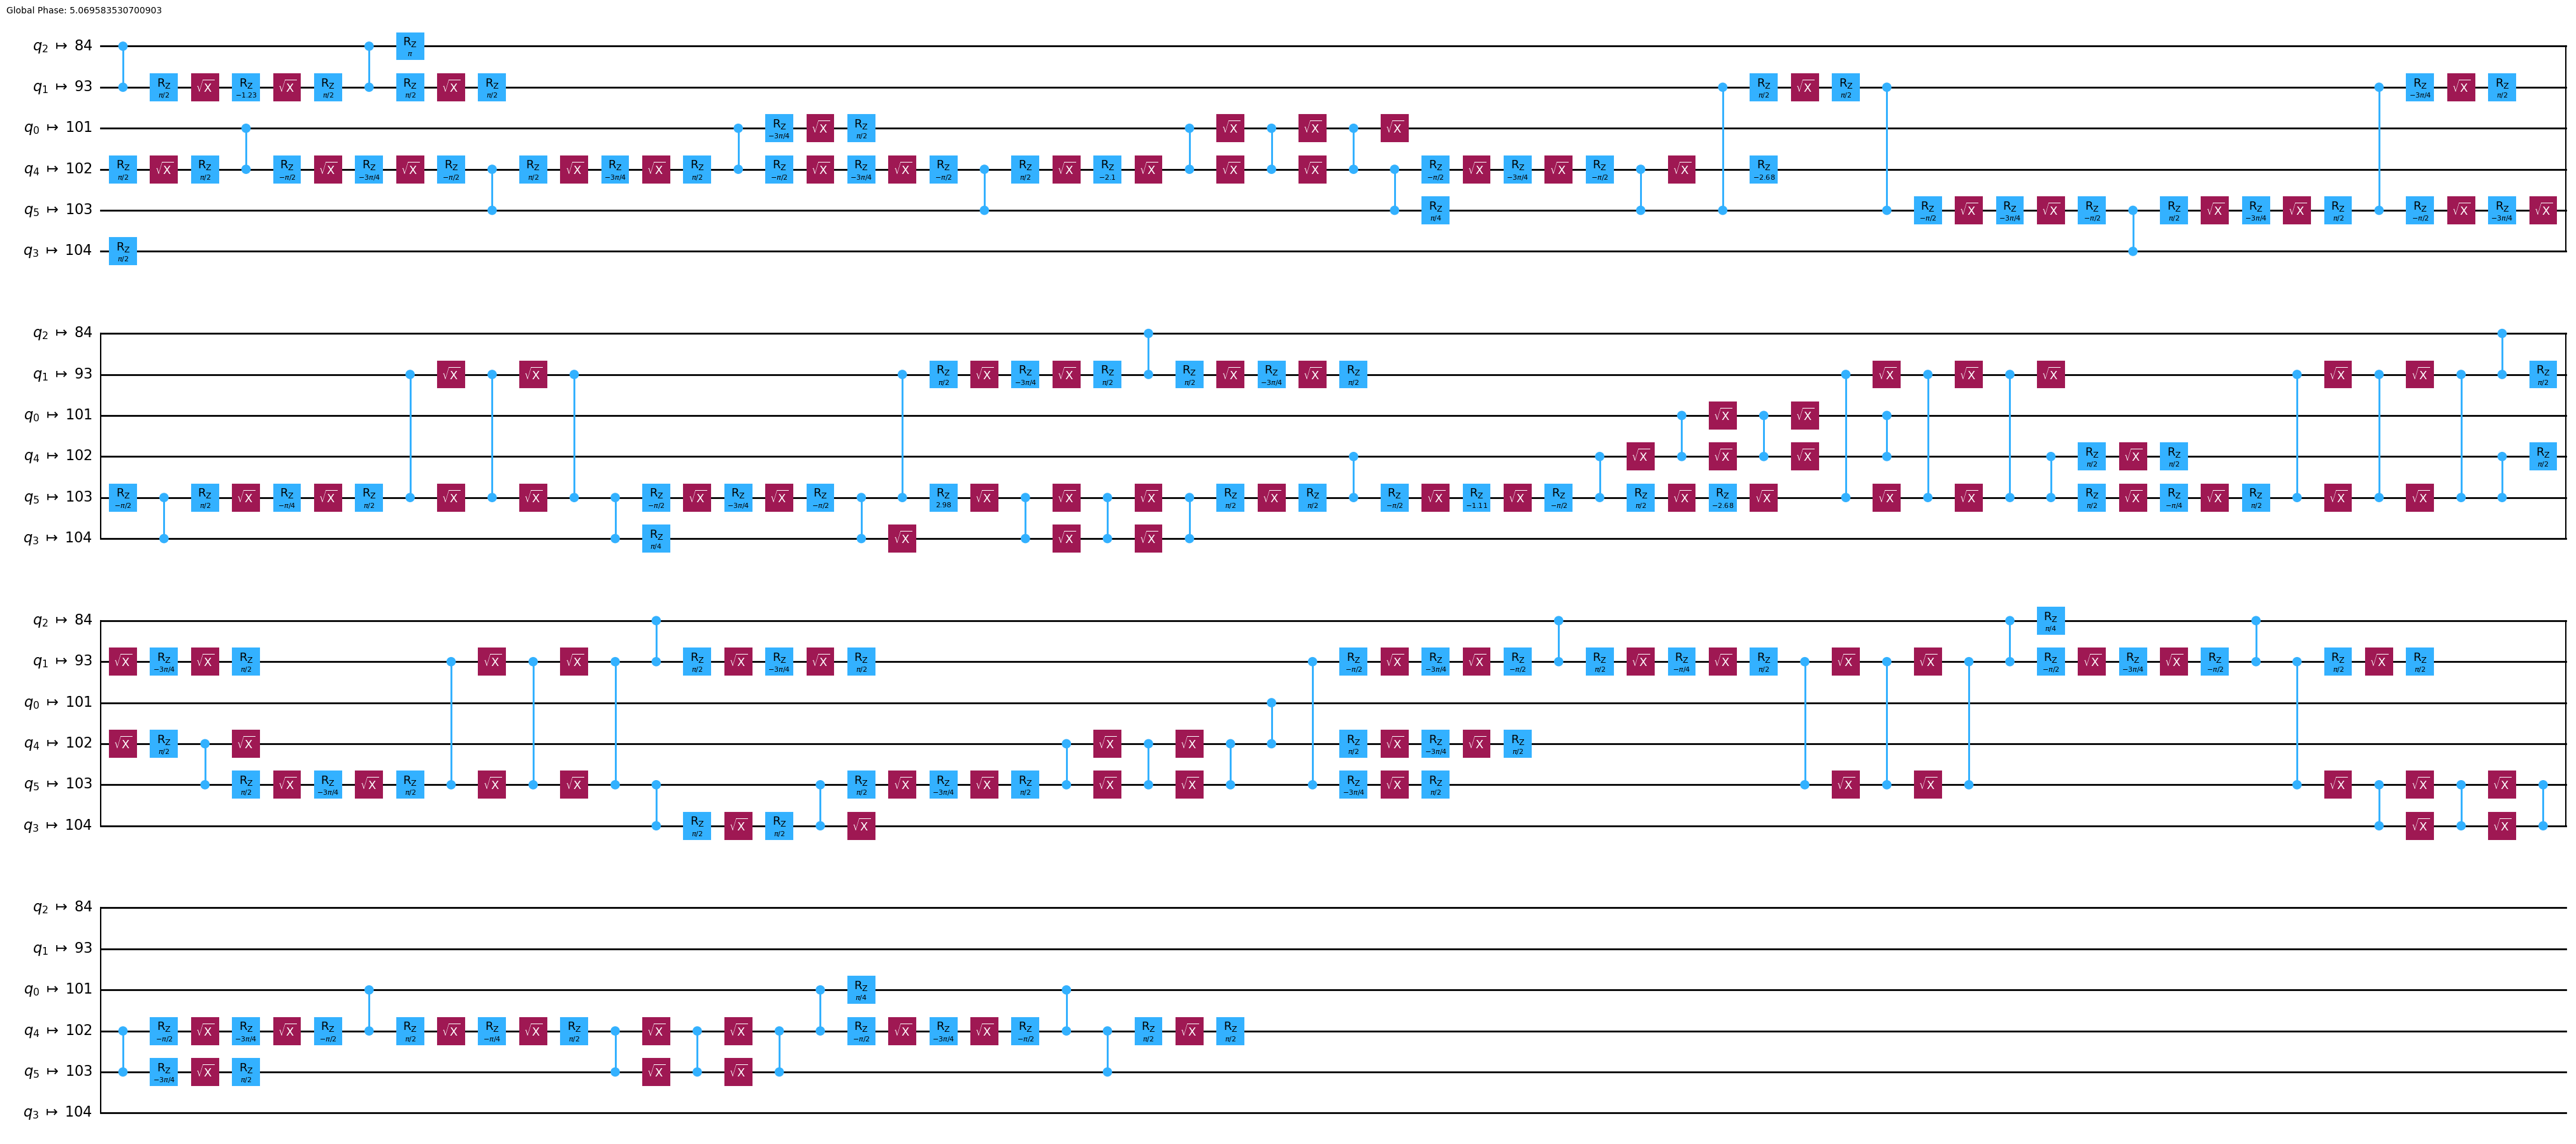

In [14]:
# Make a pass manager with our desired optimization level and backend
pm_lv1 = generate_preset_pass_manager(backend=backend, optimization_level=1)

# Run for our random circuit
tr_lv1 = pm_lv1.run(qc)

# uncomment the next line to draw circuit
tr_lv1.draw('mpl', idle_wires=False, fold=60)

You should now see logical qubits mapped into different physical qubit sets and a smaller number of gates. Just like last time, let's once again find the circuit depth of the random circuit, the sum of the total gate number, and compute the performance score of this circuit using `scoring`.

In [15]:
### Your code here ###

circuit_depths['opt_lv_1'] = tr_lv1.depth()
gate_counts['opt_lv_1'] = tr_lv1.size()
scores['opt_lv_1'] = scoring(tr_lv1, backend)

### Don't change code after this line ###

print("Optimization level 1 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_1'])
print("Gate count:", gate_counts['opt_lv_1'])
print("Score:", scores['opt_lv_1'])

Optimization level 1 results
Circuit depth: 205
Gate count: 303
Score: 933


## Optimization level = 2 <a name='opt_lv_2'></a>

Optimization level 2 performs a **`medium optimization`**, which means:

- Layout/Routing: Optimization level 1 (without trivial) + heuristic optimized with greater search depth and trials of optimization function. Because [TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout) is not used, there is no attempt to use the same physical and virtual qubit numbers.
- [CommutativeCancellation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.CommutativeCancellation#commutativecancellation)

Let's make a pass manager with `optimization_level` of 2 this time, again using `generate_preset_pass_manager` with the FakeTorino backend and `seed_transpiler` = `seed`.

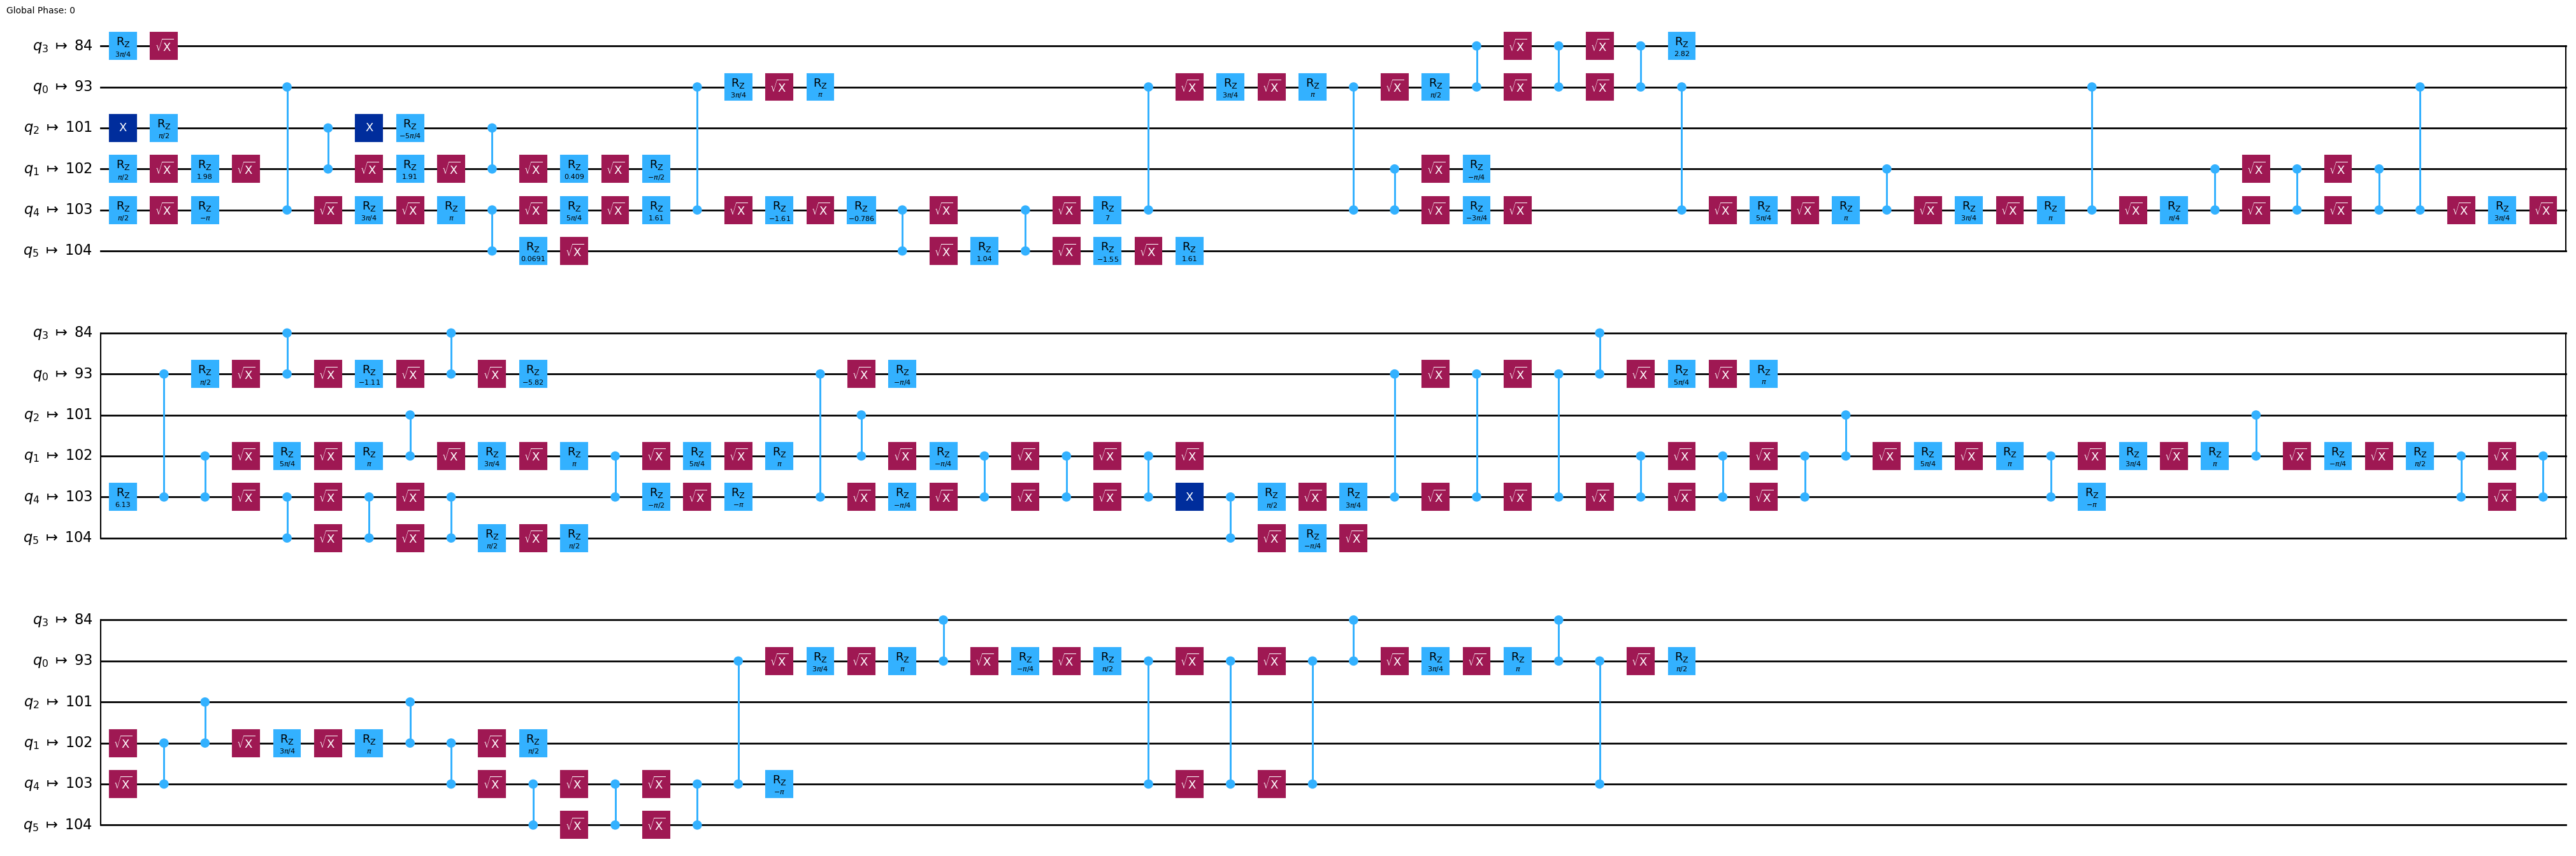

In [16]:
# Make a pass manager with our desired optimization level and backend
pm_lv2 = generate_preset_pass_manager(backend=backend, optimization_level=2)

# Run for our random circuit
tr_lv2 = pm_lv2.run(qc)

# uncomment the next line to draw circuit
tr_lv2.draw('mpl', idle_wires=False, fold=60)

Even at a glance, we can see that the number of gates has decreased quite a bit. The physical qubit to which the logical qubit is mapped remains unchanged. Now, let's measure the performance of transpiling. It is the same code as above.

In [17]:
### Your code here ###

circuit_depths['opt_lv_2'] = tr_lv2.depth()
gate_counts['opt_lv_2'] =tr_lv2.size()
scores['opt_lv_2'] =scoring(tr_lv2, backend)

### Don't change code after this line ###

print("Optimization level 2 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_2'])
print("Gate count:", gate_counts['opt_lv_2'])
print("Score:", scores['opt_lv_2'])

Optimization level 2 results
Circuit depth: 157
Gate count: 251
Score: 806


## Optimization level = 3 <a name='opt_lv_3'></a>

Optimization level 3 performs a **`high optimization`**:

- Optimization level 2 + heuristic optimized on layout/routing further with greater effort/trials
- Resynthesis of two-qubit blocks using [Cartan's KAK Decomposition](https://arxiv.org/abs/quant-ph/0507171).
- Unitarity-breaking passes:
    - `OptimizeSwapBeforeMeasure`: Remove swaps in front of measurements by re-targeting
    the classical bit of the measure instruction to avoid SWAPs
    - `RemoveDiagonalGatesBeforeMeasure`: Remove diagonal gates (like RZ, T, Z, etc.) before
    a measurement. Including diagonal 2Q gates.

You know what to do next!

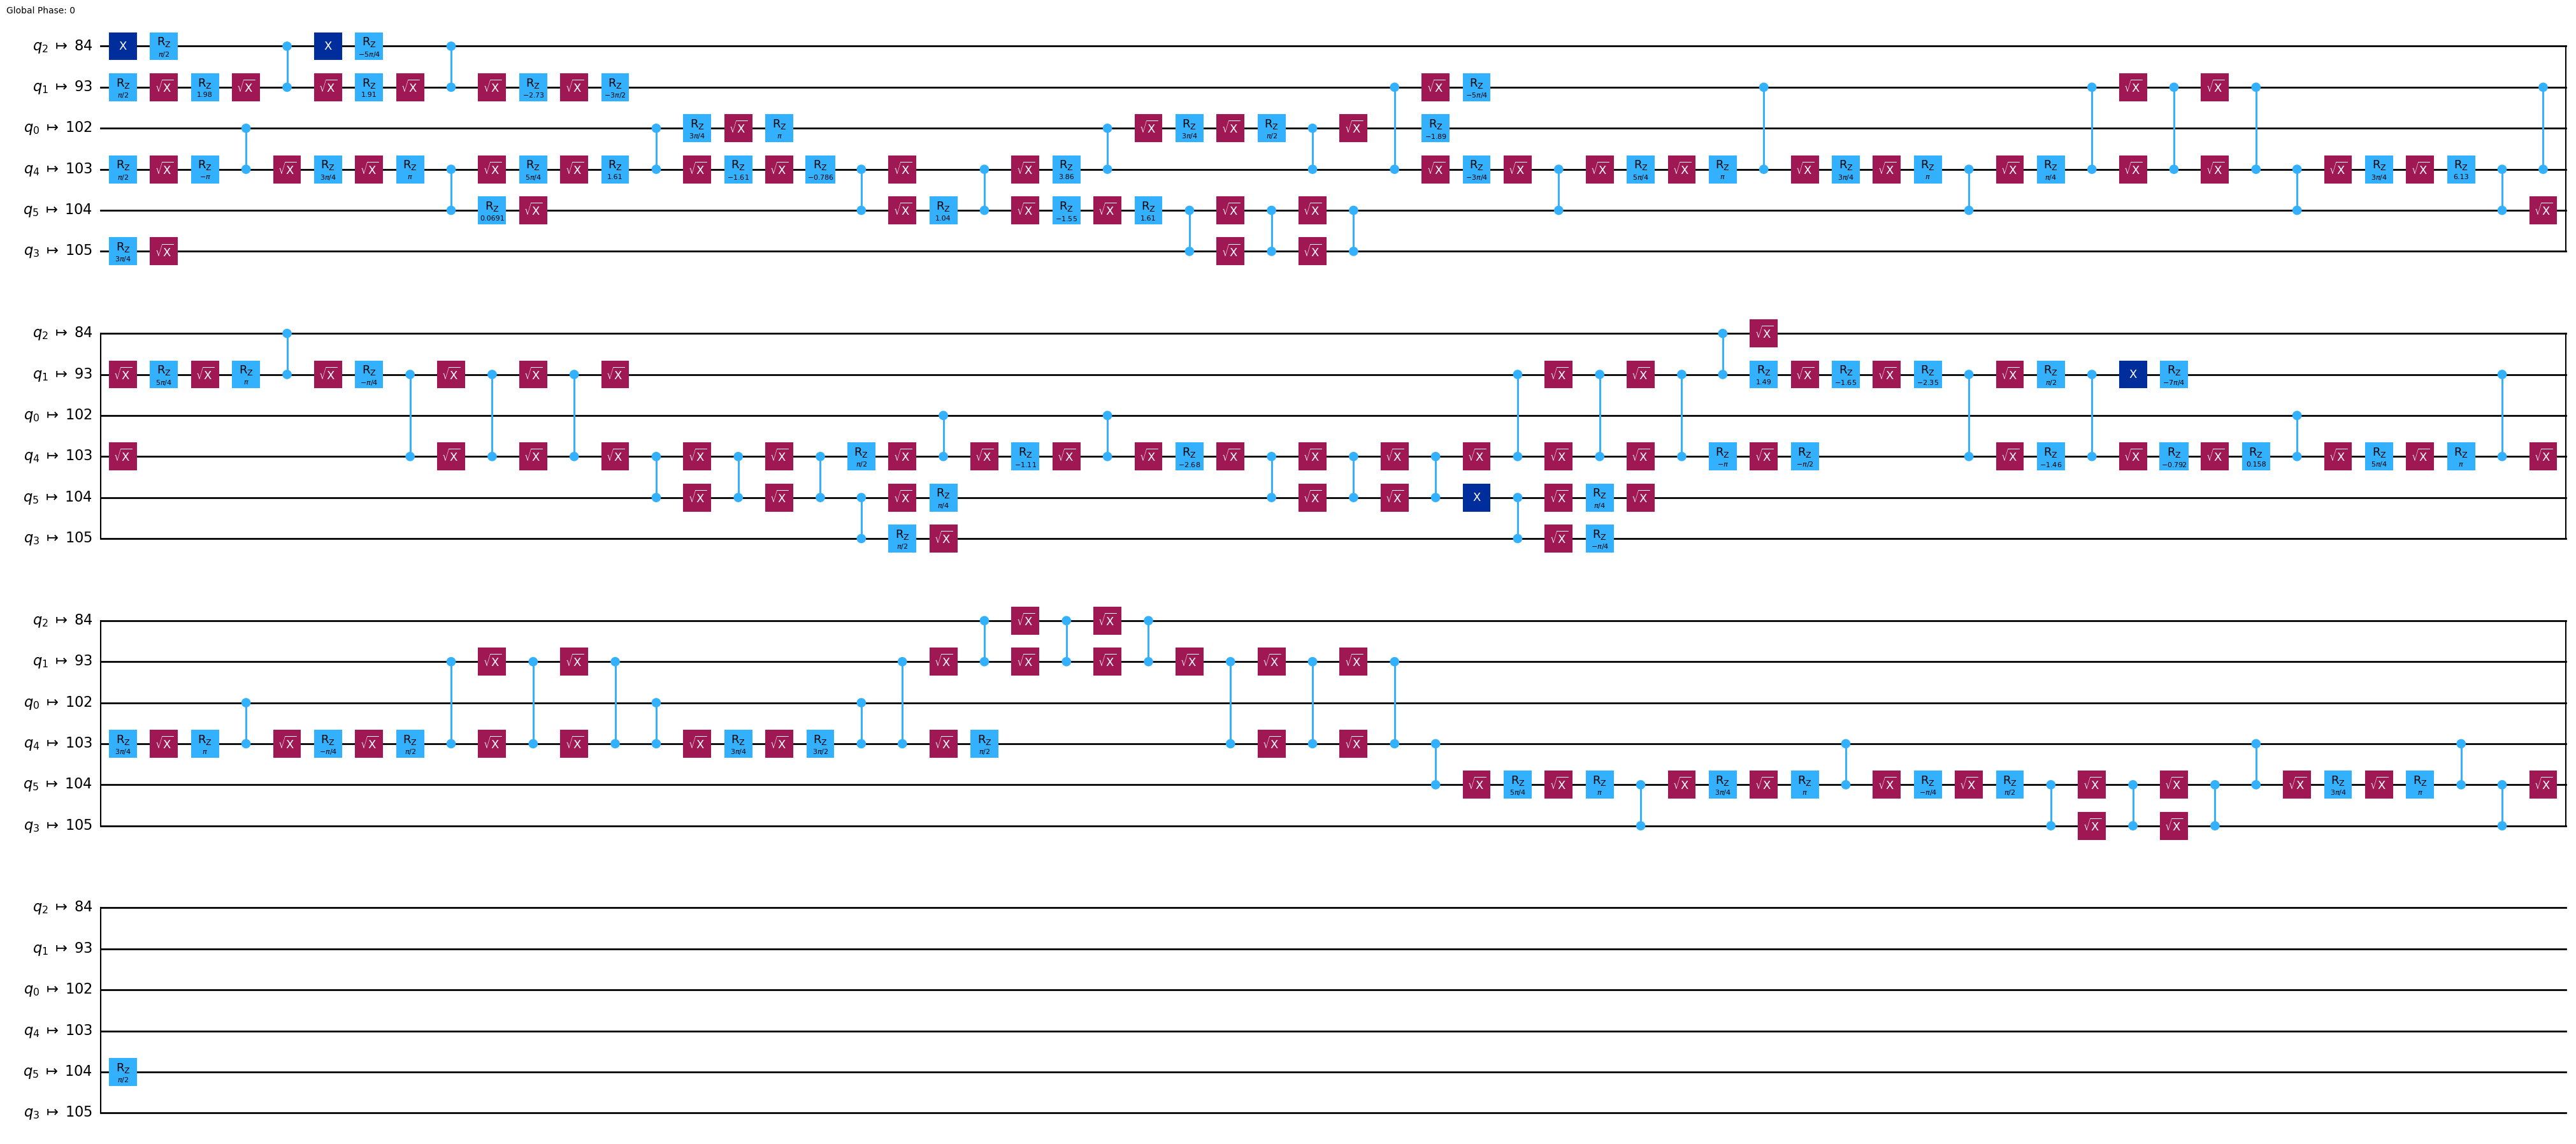

In [18]:
pm_lv3 =generate_preset_pass_manager(backend=backend, optimization_level=3)

tr_lv3 =pm_lv3.run(qc)

# uncomment to draw circuit
tr_lv3.draw('mpl', idle_wires=False, fold=60)

Surprising! Now we have a smaller number of gates! Let's see how it worked...

In [19]:
### Your code here ###

circuit_depths['opt_lv_3'] = tr_lv3.depth()
gate_counts['opt_lv_3'] = tr_lv3.size()
scores['opt_lv_3'] = scoring(tr_lv3, backend)

### Don't change code after this line ###

print("Optimization level 3 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_3'])
print("Gate count:", gate_counts['opt_lv_3'])
print("Score:", scores['opt_lv_3'])

Optimization level 3 results
Circuit depth: 180
Gate count: 263
Score: 853


Now that we have all our results, let's graph how much the depth of the circuit, the number of gates, and the evaluation score have changed according to each optimization level.

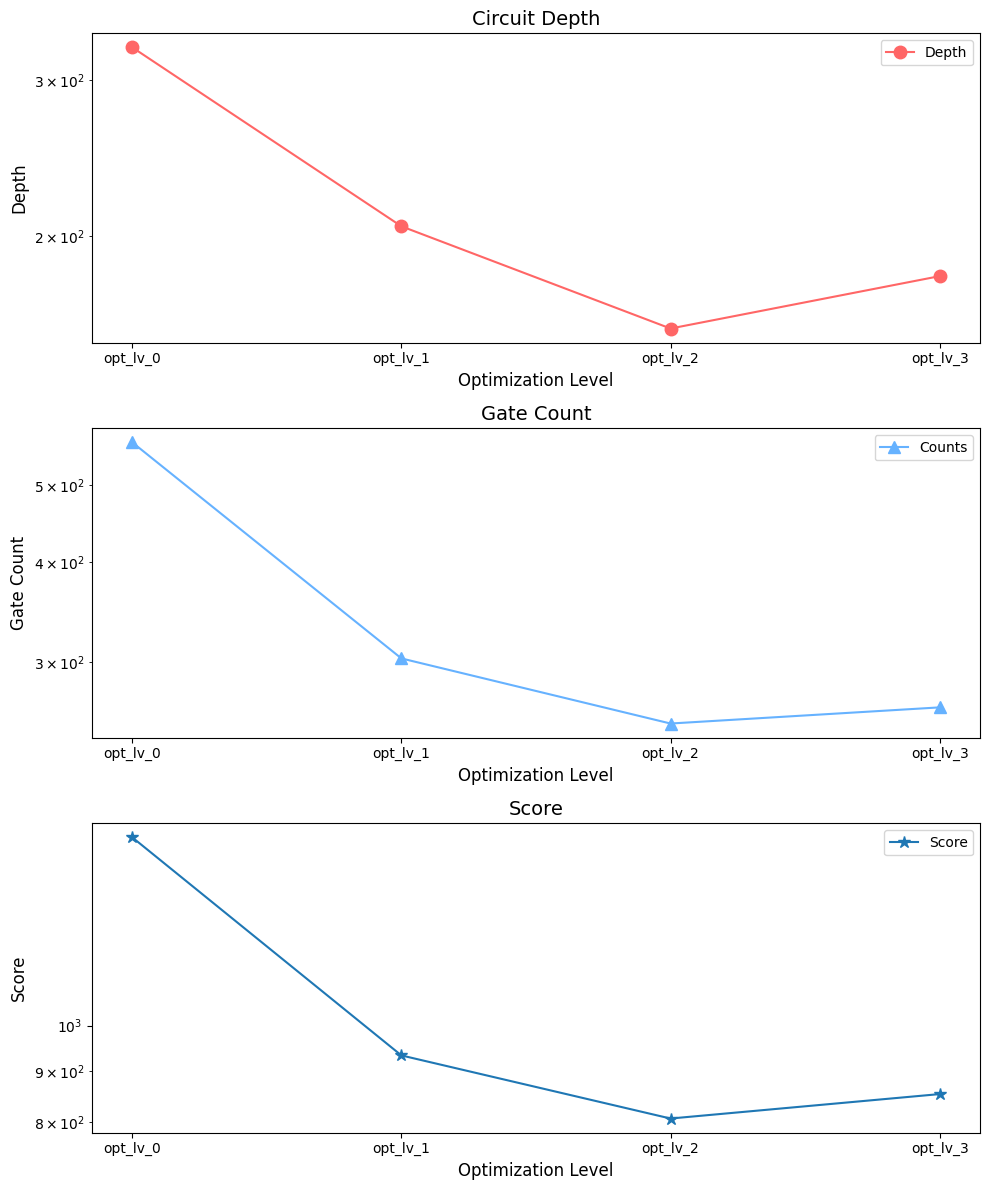

In [20]:
colors = ['#FF6666', '#66B2FF']
ax = ["opt_lv_0", "opt_lv_1", "opt_lv_2", "opt_lv_3"]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Circuit Depth
ax1.semilogy(ax, [circuit_depths[key] for key in ax],'o-',markersize=9, color='#FF6666', label="Depth")
ax1.set_xlabel("Optimization Level", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)
ax1.set_title("Circuit Depth", fontsize=14)
ax1.legend(fontsize=10)

# Plot 2: Total Number of Gates
ax2.semilogy(ax, [gate_counts[key] for key in ax],'^-',markersize=9, color='#66B2FF', label="Counts")
ax2.set_xlabel("Optimization Level", fontsize=12)
ax2.set_ylabel("Gate Count", fontsize=12)
ax2.set_title("Gate Count", fontsize=14)
ax2.legend(fontsize=10)

# Plot 3: Score of Transpiled Circuit
ax3.semilogy(ax, [scores[key] for key in ax],'*-',markersize=9, label="Score")
ax3.set_xlabel("Optimization Level", fontsize=12)
ax3.set_ylabel("Score", fontsize=12)
ax3.set_title("Score", fontsize=14)
ax3.legend(fontsize=10)

fig.tight_layout()
plt.show()

<div class="alert alert-block alert-success">

### Exercise 2: (Finish)

**Your Task:** Above you did a great amount of work to construct your different pass managers, test them, and save information about each one to it's corresponding array. You graphed that information to visibly compare your results. Now, submit all four pass managers to the grader.

Make sure you didn't change any seed values!

</div>


In [21]:
# Submit your answer using following code

answer = [pm_lv0, pm_lv1, pm_lv2, pm_lv3]

grade_lab3_ex2(answer)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


# Transpiler stage details with options <a name='transpiler_options'></a>

So far, we've looked at four predefined transpiler pipelines offered by Qiskit using random circuits. One of the key features of the Qiskit SDK v1.0 transpiler is the ease with which users can build and configure a custom passmanager. Configure your own pass manager by using six standard passes along with the optimization level discussed above, but also choosing the option or plug-in for each pass as you like. Another way is to create your pass manager with as many passes as you want by using `StagedPassManager`. In addition, you can create and deploy a new pass manager and implement it in the the form of a [plugin](https://docs.quantum.ibm.com/transpile/create-a-transpiler-plugin) in Qiskit so that other users can use it.

Let's look at all three methods in the following sections, starting with the easiest way first.

## Init stage <a name='init'></a>

This first stage does very little by default and is primarily useful if you want to include your own initial optimizations. Because most layout and routing algorithms are only designed to work with single- and two-qubit gates, this stage is also used to translate any gates that operate on more than two qubits, into gates that only operate on one or two qubits.

If you specify an argument at this stage for the qubits you want to use, that value overrides all the passes that could change it. You can find more details in the [Default settings and configuration options documentation](https://docs.quantum.ibm.com/transpile/defaults-and-configuration-options).

First, let's check the possible options of the init stage we can use.

Without extra plugins, only default options exist. This process includes several transpiler pass plugins depending on the `optimization_level` - let's take a look inside it.

For this, let's create a pass manager with `init_method="default"` options.

In [22]:
list_stage_plugins("init")

['default']

Without extra plugins, only default options exist. This process includes several transpiler pass plugins depending on the `optimization_level` - let's take a look inside it.

For this, let's create a pass manager with `init_method="default"` options.

In [23]:
print("Plugins run by default init stage")
print("=================================")

for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, init_method="default", seed_transpiler=1000)
    for task in pm.init.to_flow_controller().tasks:
        print(" -", type(task).__name__)

Plugins run by default init stage

Optimization level 0:
 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator

Optimization level 1:
 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator
 - InverseCancellation

Optimization level 2:
 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator
 - ElidePermutations
 - RemoveDiagonalGatesBeforeMeasure
 - InverseCancellation
 - CommutativeCancellation
 - Collect2qBlocks
 - ConsolidateBlocks
 - Split2QUnitaries

Optimization level 3:
 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator
 - ElidePermutations
 - RemoveDiagonalGatesBeforeMeasure
 - InverseCancellation
 - CommutativeCancellation
 - Collect2qBlocks
 - ConsolidateBlocks
 - Split2QUnitaries


Here is a table of each plugin's API docs. Take a look if you want to dive more deeply into any of them.

| Plugin | Description | API docs link|
|---- | ---- | ------|
|UnitarySynthesis| Synthesize unitaries over some basis gates | https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.UnitarySynthesis#unitarysynthesis |
|HighLevelSynthesis |Synthesize higher-level objects and unroll custom definitions| https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.HighLevelSynthesis#highlevelsynthesis |
| BasisTranslator | Translates gates to a target basis by searching for a set of translations from a given EquivalenceLibrary | https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.BasisTranslator#basistranslator |
| InverseCancellation| Cancel specific gates which are inverses of each other when they occur back-to- back | https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.InverseCancellation#inversecancellation |
| OptimizeSwapBeforeMeasure | Moves the measurements around to avoid SWAPs | NA |
| RemoveDiagonalGatesBeforeMeasure | Remove diagonal gates (including diagonal 2Q gates) before a measurement | https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.RemoveDiagonalGatesBeforeMeasure |


## Layout stage <a name='layout'></a>

The next stage involves the layout or connectivity of the backend a circuit will be sent to. In general, quantum circuits are abstract entities whose qubits are "virtual" or "logical" representations of actual qubits used in computations. To execute a sequence of gates, a one-to-one mapping from the "virtual" qubits to the "physical" qubits in an actual quantum device is necessary. This mapping is stored as a Layout object and is part of the constraints defined within a backend's instruction set architecture (ISA).


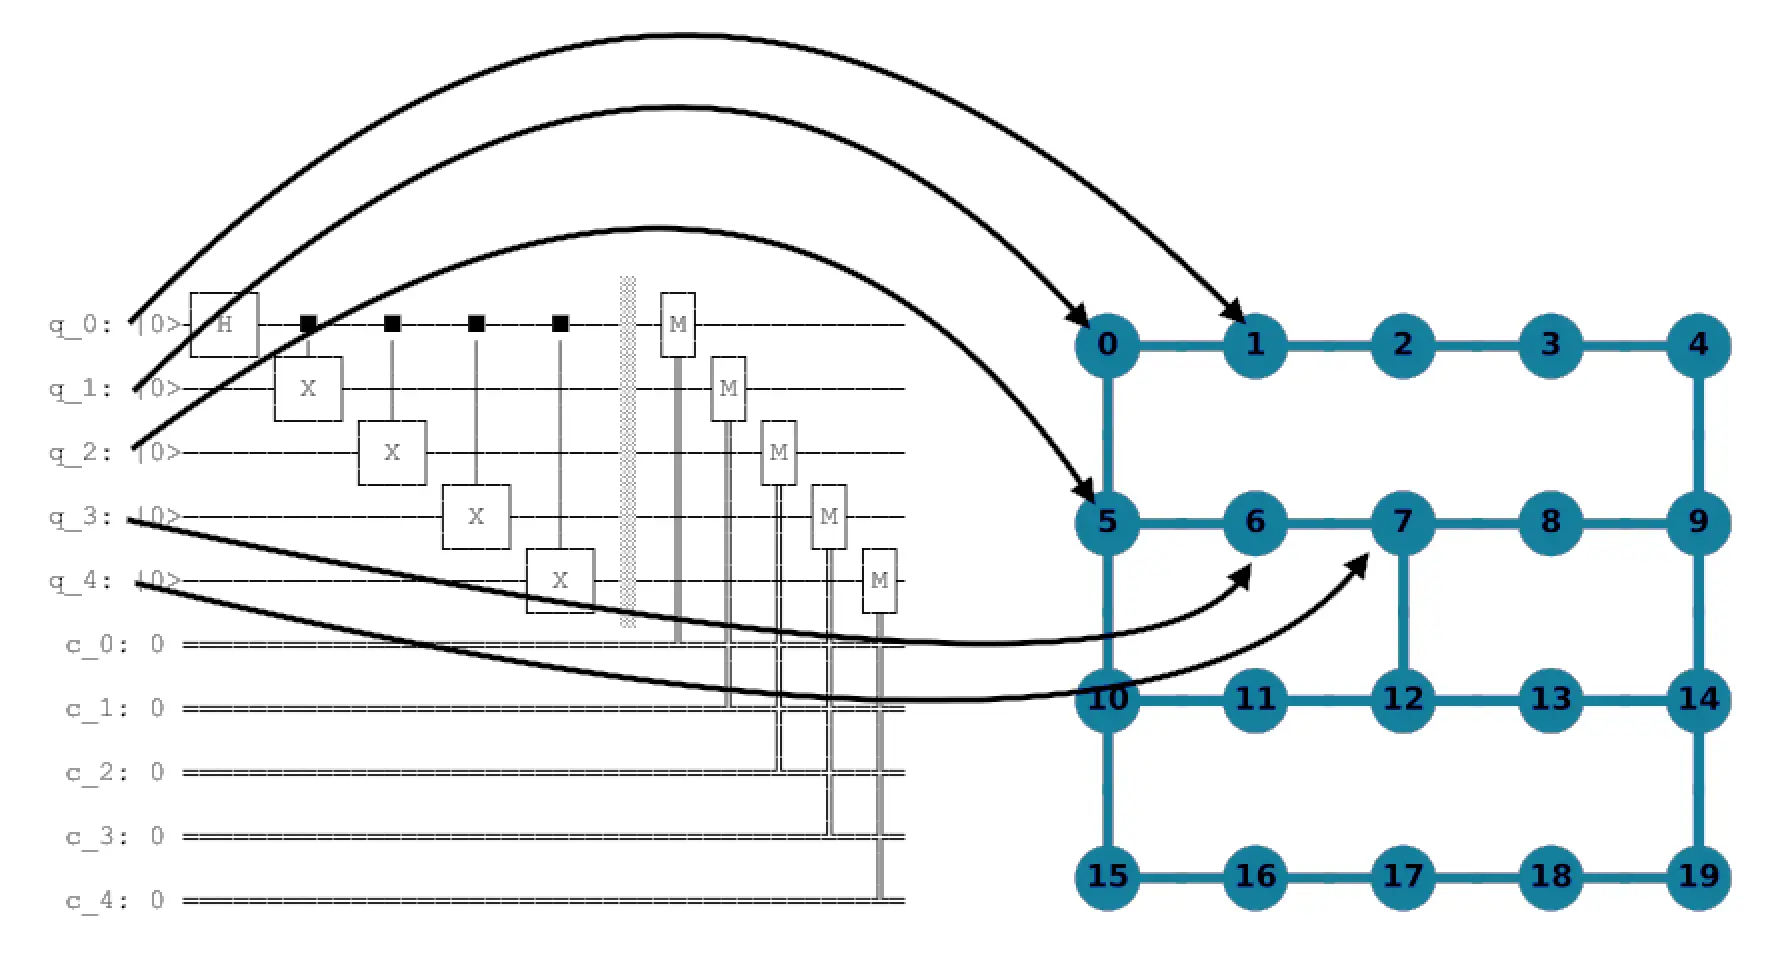


The choice of mapping is extremely important for minimizing the number of SWAP operations needed to map the input circuit onto the device topology and ensure the most well-calibrated qubits are used. Due to the importance of this stage, the preset pass managers try a few different methods to find the best layout. Typically this involves two steps: first, try to find a "perfect" layout (a layout that does not require any SWAP operations), and then, a heuristic pass that tries to find the best layout to use if a perfect layout cannot be found. There are two Passes typically used for this first step:

- [TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout): Naively maps each virtual qubit to the same numbered physical qubit on the device (i.e., [0,1,1,3] -> [0,1,1,3]). This is historical behavior only used in optimzation_level=1 to try to find a perfect layout. If it fails, VF2Layout is tried next.
- [VF2Layout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.VF2Layout): This is an AnalysisPass that selects an ideal layout by treating this stage as a subgraph isomorphism problem, solved by the VF2++ algorithm. If more than one layout is found, a scoring heuristic is run to select the mapping with the lowest average error.
  
Then for the heuristic stage, two passes are used by default:

- [DenseLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.DenseLayout): Finds the sub-graph of the device with the greatest connectivity and that has the same number of qubits as the circuit (used for optimization level 1 if there are control flow operations (such as IfElseOp) present in the circuit).
- [SabreLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.SabreLayout): This pass selects a layout by starting from an initial random layout and repeatedly running the SabreSwap algorithm. This pass is only used in optimization levels 1, 2, and 3 if a perfect layout isn't found via the VF2Layout pass. For more details on this algorithm, refer to the paper [arXiv:1809.02573](arXiv:1809.02573).

We can find these four passes by using the same code as the init stage.

In [24]:
list_stage_plugins("layout")

['default', 'dense', 'sabre', 'trivial']

First, let's check which tasks will be enabled by which optimization_level with the `layout_method='default'` option by running the code below.

Plugins run by default layout stage

Optimization level 0:
 -  TrivialLayout
[5, 4, 0, 2, 1, 3]


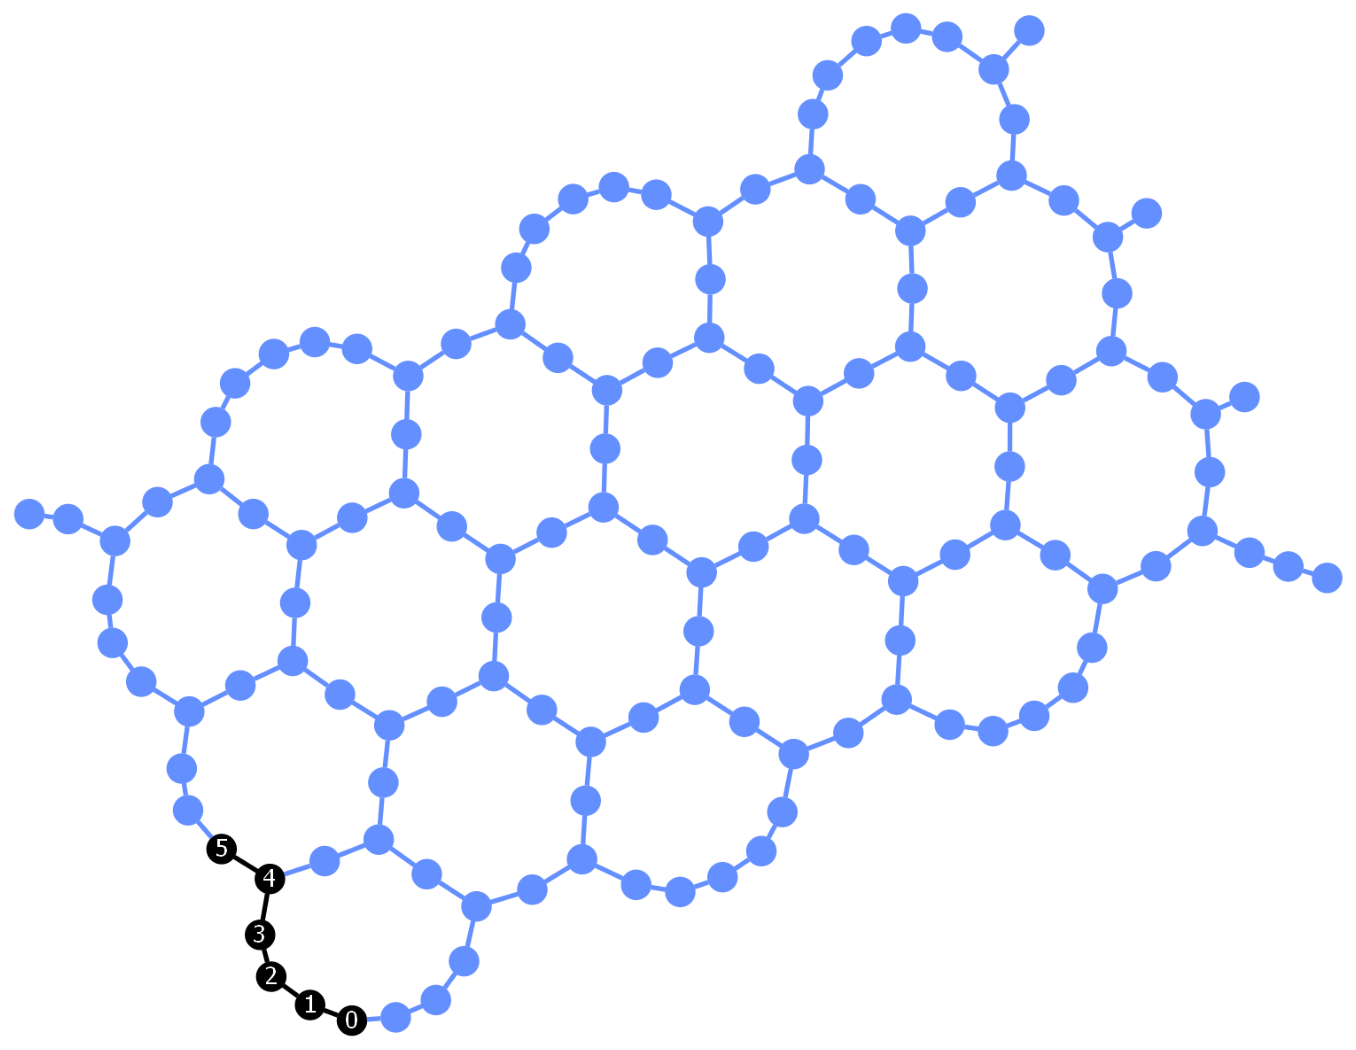


Optimization level 1:
 -  TrivialLayout
 -  CheckMap
 -  VF2Layout
 -  BarrierBeforeFinalMeasurements
 -  SabreLayout
 -  FlowControllerLinear
[65, 66, 86, 68, 74, 67]


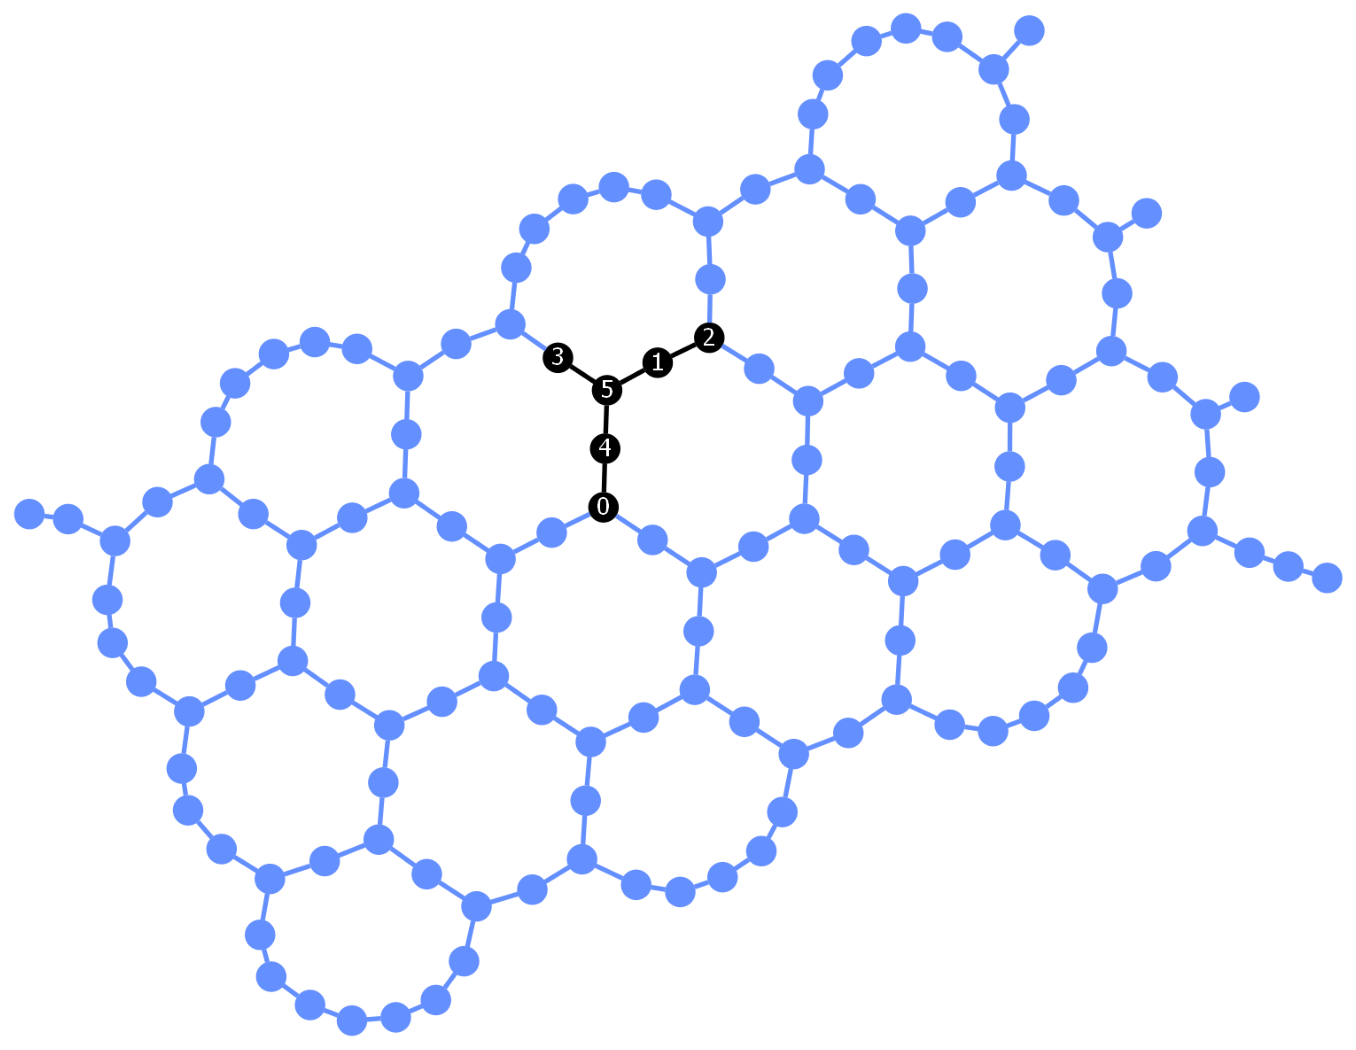


Optimization level 2:
 -  VF2Layout
 -  BarrierBeforeFinalMeasurements
 -  SabreLayout
 -  FlowControllerLinear
[46, 55, 63, 66, 64, 65]


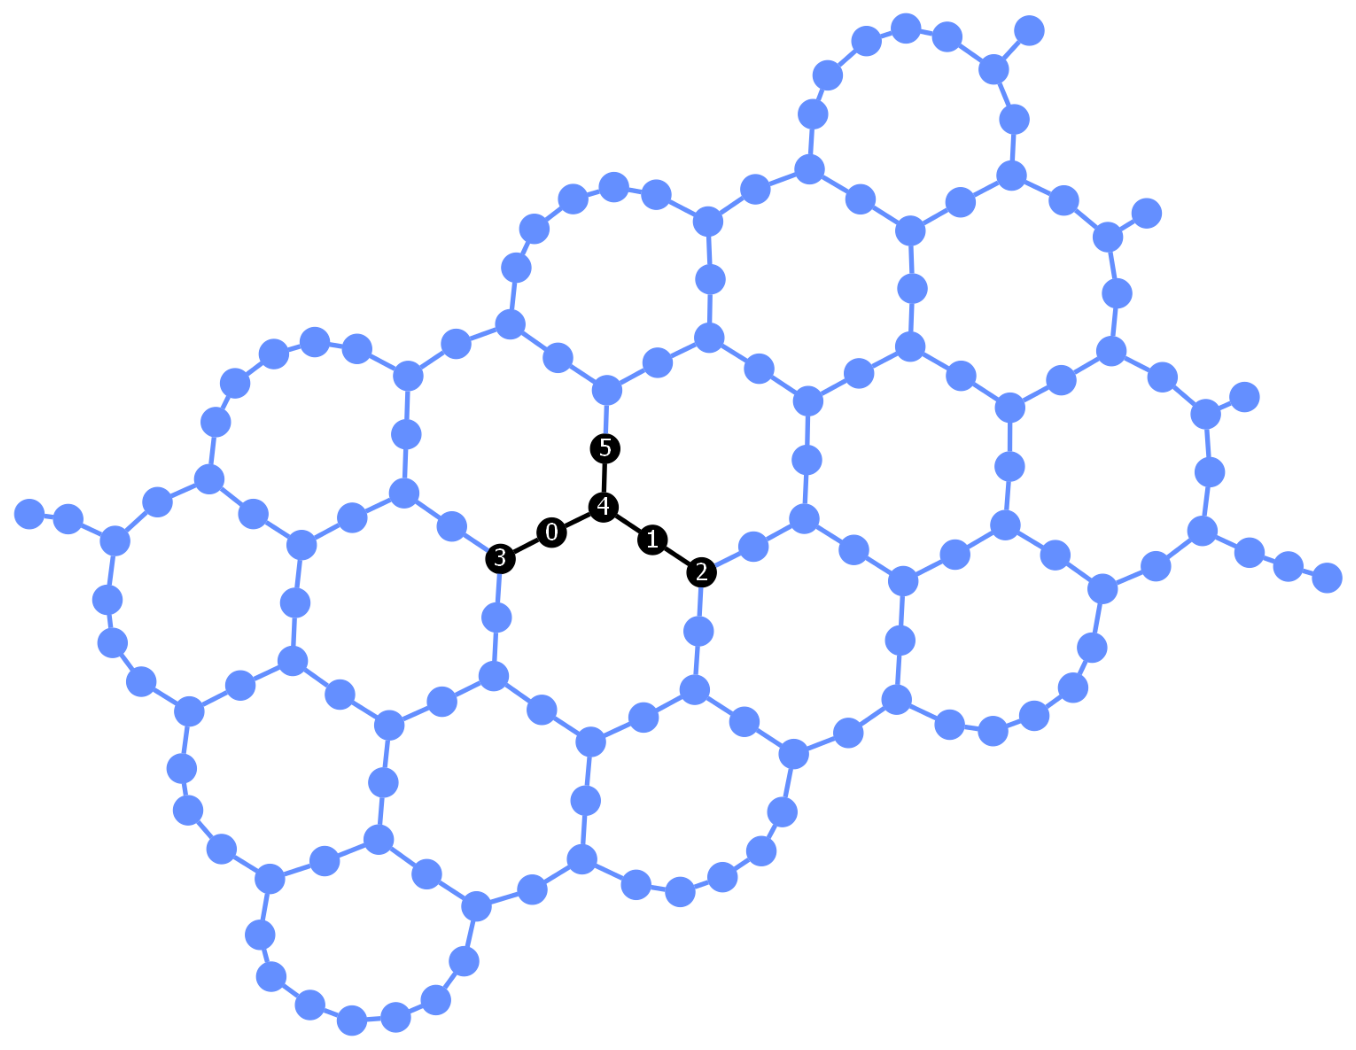


Optimization level 3:
 -  VF2Layout
 -  BarrierBeforeFinalMeasurements
 -  SabreLayout
 -  FlowControllerLinear
[63, 64, 46, 66, 55, 65]


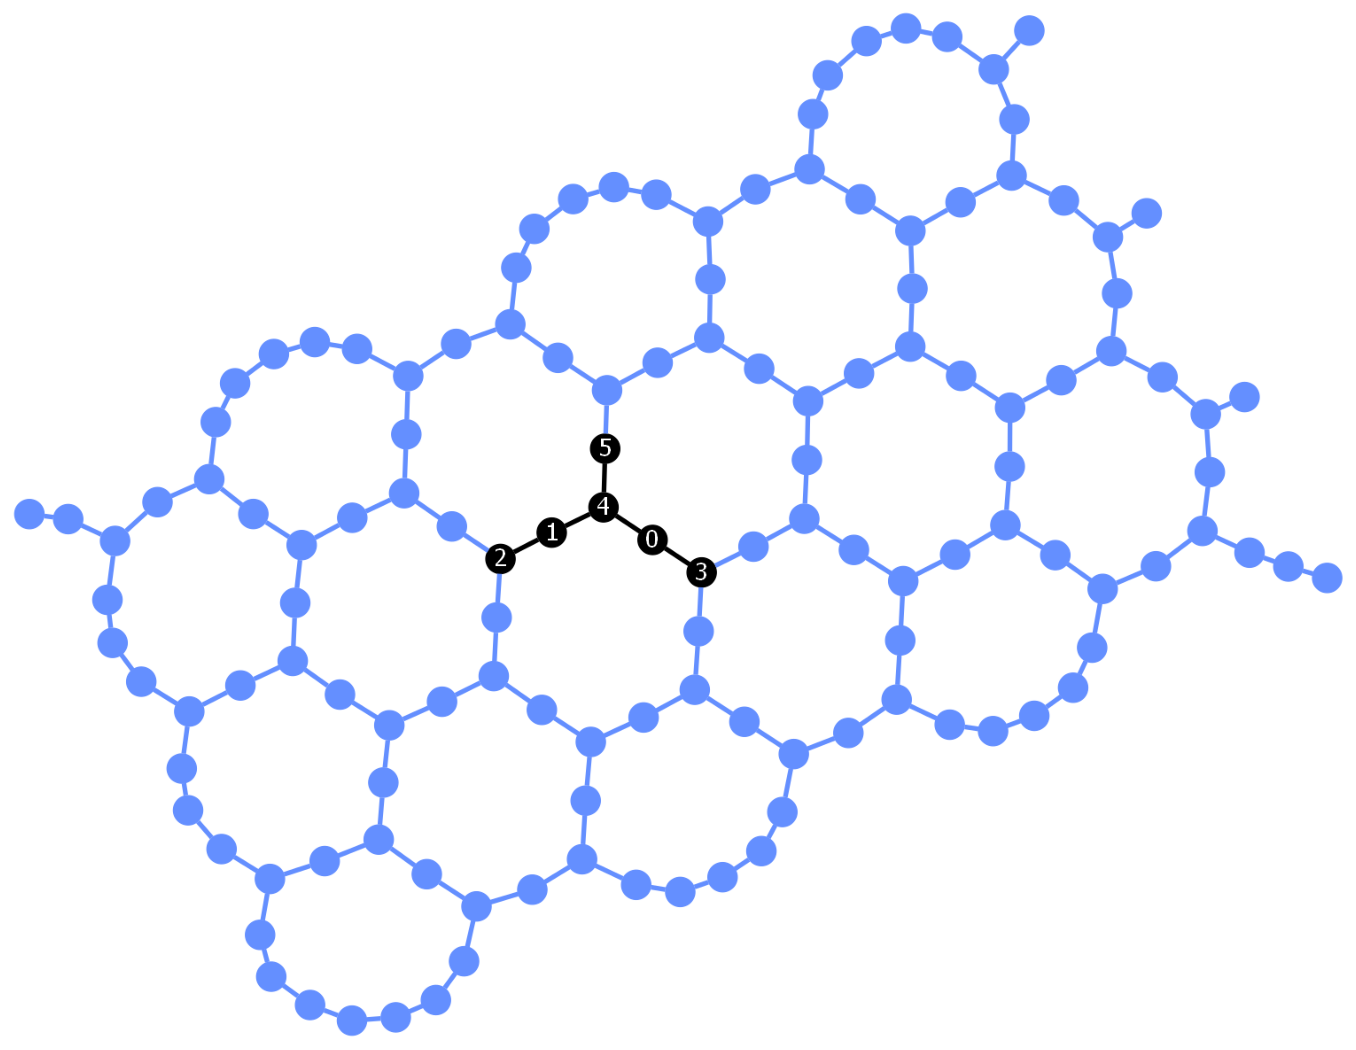

In [25]:
print("Plugins run by default layout stage")
print("=================================")
for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, layout_method='default', seed_transpiler=seed)
    qc_tr = pm.run(qc)

    for controller_group in pm.layout.to_flow_controller().tasks:
        tasks = getattr(controller_group, "tasks", [])
        for task in tasks:
            print(" - " , str(type(task).__name__))
    print(qc_tr.layout.final_index_layout())
    display(plot_circuit_layout(pm.run(qc), backend))

Now let's compare the score and layout of each option with optimization_level=3.

In [26]:
for option in list_stage_plugins("layout"):
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, layout_method=option, seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)

    print(f"Layout method = {option}")
    print(f"Score: {score}")
    print(f"Layout: {qc_tr.layout.final_index_layout()}\n")

Layout method = default
Score: 806
Layout: [63, 64, 46, 66, 55, 65]

Layout method = dense
Score: 1039
Layout: [37, 52, 49, 56, 50, 51]

Layout method = sabre
Score: 806
Layout: [63, 64, 46, 66, 55, 65]

Layout method = trivial
Score: 1109
Layout: [5, 4, 0, 2, 1, 3]



## Routing stage <a name='routing'></a>

In order to implement a two-qubit gate between qubits that are not directly connected on a quantum device, one or more SWAP gates must be inserted into the circuit to move the qubit states around until they are adjacent on the device gate map. Each SWAP gate represents an expensive and noisy operation to perform. Thus, finding the minimum number of SWAP gates needed to map a circuit onto a given device is an important step in the transpilation process. For efficiency, this stage is typically computed alongside the Layout stage by default, but they are logically distinct from one another. The Layout stage selects the hardware qubits to be used, while the Routing stage inserts the appropriate amount of SWAP gates in order to execute the circuits using the selected layout.

However, finding the optimal SWAP mapping is hard. In fact, it is an NP-hard problem, and is thus prohibitively expensive to compute for all but the smallest quantum devices and input circuits. To work around this, Qiskit uses a stochastic heuristic algorithm called SabreSwap to compute a good, but not necessarily optimal, SWAP mapping. The use of a stochastic method means that the circuits generated are not guaranteed to be the same over repeated runs. Indeed, running the same circuit repeatedly results in a distribution of circuit depths and gate counts at the output. It is for this reason that many users choose to run the routing function (or the entire StagedPassManager) many times and select the lowest-depth circuits from the distribution of outputs.

In [27]:
list_stage_plugins("routing")

['basic', 'lookahead', 'none', 'sabre', 'stochastic']

In [28]:
print("Number of each gates of transpiled circuit and the score")
print("=================================")
for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, routing_method='basic', seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)
    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print(f"Score: {score}")

Number of each gates of transpiled circuit and the score

Optimization level 0:
sx : 271
rz : 222
cz : 127
Score: 1763

Optimization level 1:
sx : 167
rz : 115
cz : 91
Score: 1192

Optimization level 2:
sx : 162
cz : 82
rz : 80
x : 3
Score: 1062

Optimization level 3:
sx : 162
cz : 82
rz : 80
x : 3
Score: 1062


In [29]:
print("Plugins run by basic routing stage")
print("=================================")
import time
for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, routing_method='basic', seed_transpiler=seed)

    for controller_group in pm.routing.to_flow_controller().tasks:
        tasks = getattr(controller_group, "tasks", [])
        for task in tasks:
            print(" - " , str(type(task).__name__))
    print(pm.run(qc).layout.final_index_layout())

Plugins run by basic routing stage

Optimization level 0:
 -  BarrierBeforeFinalMeasurements
 -  BasicSwap
[2, 0, 5, 4, 3, 1]

Optimization level 1:
 -  BarrierBeforeFinalMeasurements
 -  BasicSwap
 -  VF2PostLayout
 -  ApplyLayout
[22, 25, 23, 16, 4, 24]

Optimization level 2:
 -  BarrierBeforeFinalMeasurements
 -  BasicSwap
 -  VF2PostLayout
 -  ApplyLayout
[25, 27, 35, 44, 24, 26]

Optimization level 3:
 -  BarrierBeforeFinalMeasurements
 -  BasicSwap
 -  VF2PostLayout
 -  ApplyLayout
[25, 27, 35, 44, 24, 26]


In [30]:
## process stopped due to lookahead
options = ['basic','sabre', 'stochastic']

for option in options:
    print(f"Layout option = {option}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, routing_method=option, seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)

    print(f"Score: {score}")

    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print("\n")

Layout option = basic:
Score: 1062
sx : 162
cz : 82
rz : 80
x : 3


Layout option = sabre:
Score: 806
sx : 111
rz : 75
cz : 62
x : 3


Layout option = stochastic:
Score: 1163
sx : 169
cz : 91
rz : 84
x : 5




## Translation stage <a name='translation'></a>

When writing a quantum circuit, you are free to use any quantum gate (unitary operation) that you like, along with a collection of non-gate operations such as qubit measurement or reset instructions. However, most quantum devices only natively support a handful of quantum gate and non-gate operations. These native gates are part of the definition of a target's ISA and this stage of the preset PassManagers translates (or unrolls) the gates specified in a circuit to the native basis gates of a specified backend. This is an important step, as it allows the circuit to be executed by the backend, but typically leads to an increase in the depth and number of gates.

Two special cases are especially important to highlight, and help illustrate what this stage does.

1. If a SWAP gate is not a native gate to the target backend, this requires three CNOT gates: As a product of three CNOT gates, a SWAP is an expensive operation to perform on noisy quantum devices. However, such operations are usually necessary for embedding a circuit into the limited gate connectivities of many devices. Thus, minimizing the number of SWAP gates in a circuit is a primary goal in the transpilation process.

2. A Toffoli, or controlled-controlled-not gate (ccx), is a three-qubit gate. Given that our basis gate set includes only single- and two-qubit gates, this operation must be decomposed. However, it is quite costly: For every Toffoli gate in a quantum circuit, the hardware may execute up to six CNOT gates and a handful of single-qubit gates. This example demonstrates that any algorithm making use of multiple Toffoli gates will end up as a circuit with large depth and will therefore be appreciably affected by noise.

Let's check how many options we can use.

In [31]:
list_stage_plugins("translation")

['synthesis', 'translator', 'ibm_backend', 'ibm_dynamic_circuits']

The basic options in Qiskit are 'translator' and 'synthesis'. Let's count the total gate numbers, circuit depth, and scores of transpiled circuits with the default option ('translator') and each optimization level.

In [32]:
print("Number of each gates of transpiled circuit")
print("=================================")

for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, translation_method='translator', seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)
    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print(f"Score: {score}")

Number of each gates of transpiled circuit

Optimization level 0:
sx : 235
rz : 222
cz : 109
Score: 1547

Optimization level 1:
sx : 120
rz : 113
cz : 70
Score: 933

Optimization level 2:
sx : 111
rz : 75
cz : 62
x : 3
Score: 806

Optimization level 3:
sx : 111
rz : 75
cz : 62
x : 3
Score: 806


Let's count total gate numbers, circuit depth, and scores of transpiled circuits with each option and optimization_level=3.

In [33]:
options = ['translator', 'synthesis']

print("Number of each gates of transpiled circuit")
print("=================================")

for option in options:
    print(f"Layout option = {option}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, translation_method=option, seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)
    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print(f"Score: {score}")
    print("\n")

Number of each gates of transpiled circuit
Layout option = translator:
sx : 111
rz : 75
cz : 62
x : 3
Score: 806


Layout option = synthesis:
sx : 122
rz : 112
cz : 62
x : 7
Score: 854




Let's plot it on a graph.

In [34]:
tr_depths = []
tr_gate_counts = []
tr_scores = []

options = ['translator', 'synthesis']

for i in range(4):
    for option in options:
        pm = generate_preset_pass_manager(backend=backend, optimization_level=i, translation_method=option, seed_transpiler=seed)

        tr_depths.append(pm.run(qc).depth())
        tr_gate_counts.append(sum(pm.run(qc).count_ops().values()))
        tr_scores.append(scoring(pm.run(qc), backend))

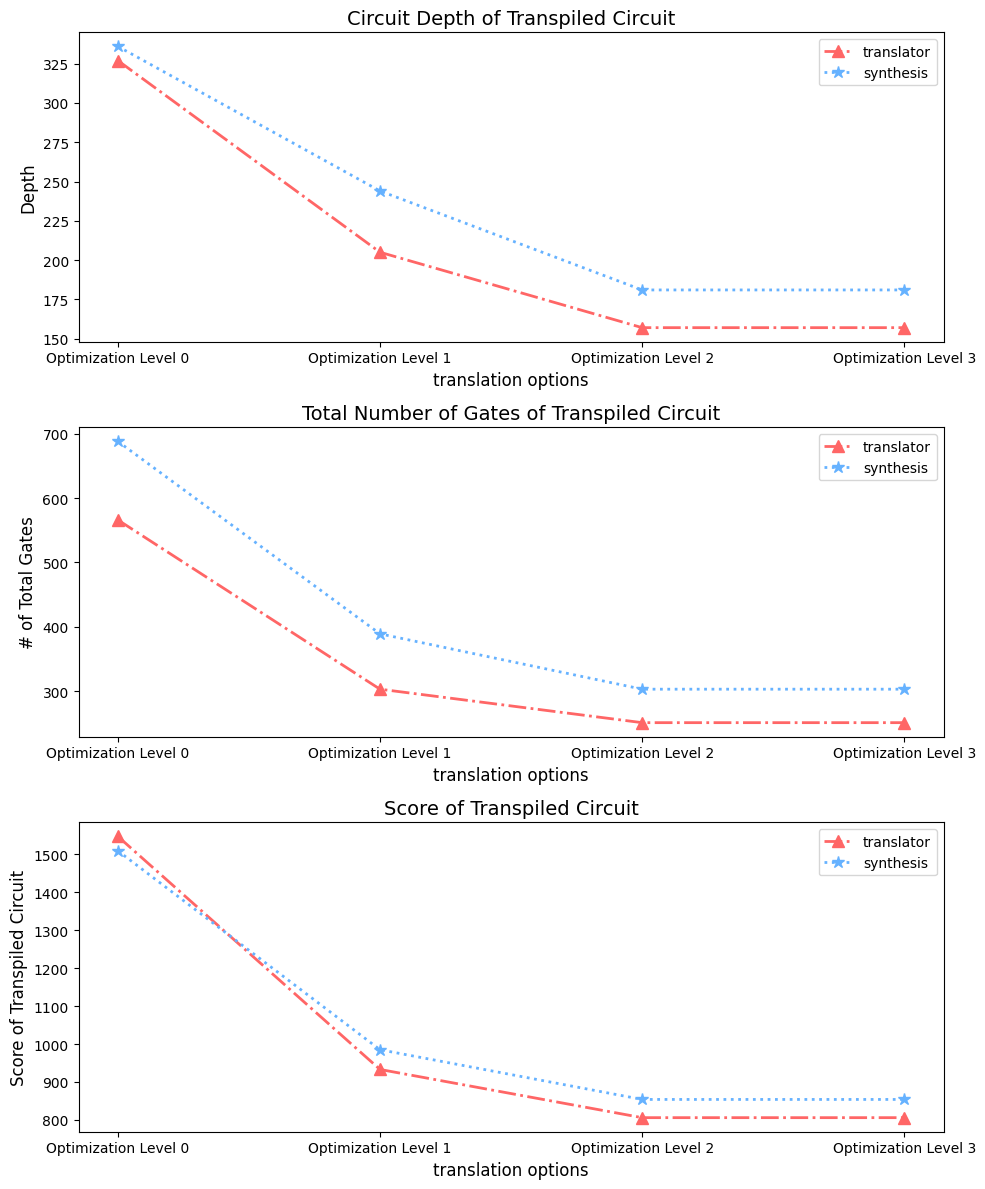

In [35]:
colors = ['#FF6666', '#66B2FF']
markers = [ '^', '*']
linestyles = ['-.', ':']

opt_list = []
for i in range(4):
    opt_list.append(f"Optimization Level {i}")

ax = opt_list
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Circuit Depth
for i in range(2):
    ax1.plot(ax, tr_depths[i::2], label=options[i], marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax1.set_xlabel("translation options", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)
ax1.set_title("Circuit Depth of Transpiled Circuit", fontsize=14)
ax1.legend(fontsize=10)

# Plot 2: Total Number of Gates
for i in range(2):
    ax2.plot(ax, tr_gate_counts[i::2], label=options[i], marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax2.set_xlabel("translation options", fontsize=12)
ax2.set_ylabel("# of Total Gates", fontsize=12)
ax2.set_title("Total Number of Gates of Transpiled Circuit", fontsize=14)
ax2.legend(fontsize=10)

# Plot 3: Score of Transpiled Circuit
for i in range(2):
    ax3.plot(ax, tr_scores[i::2], label=options[i], marker=markers[i],markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax3.set_xlabel("translation options", fontsize=12)
ax3.set_ylabel("Score of Transpiled Circuit", fontsize=12)
ax3.set_title("Score of Transpiled Circuit", fontsize=14)
ax3.legend(fontsize=10)

fig.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<a id='ex4'></a>
<a name='ex4'></a>

### Exercise 3:

**Your Task:** At this point, you should feel like a professional at constructing different pass managers. Please make a pass manager with the following options:

1. optimization level = 3
2. "sabre" layout
3. "sabre" routing
4. "synthesis" translation
   
</div>

In [36]:
pm_ex3 = generate_preset_pass_manager(
    backend=backend,

    ### Write your code below here ###
    optimization_level=3,
    layout_method='sabre',
    routing_method='sabre',
    translation_method='synthesis'


    ### Don't change any code past this line ###
)

In [37]:
# Submit your answer using following code

grade_lab3_ex3(pm_ex3)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


## (Bonus) Ecosystem and Qiskit Transpiler plugin <a name='plugin'></a>

To facilitate the development and reuse of custom transpilation code by the wider community of Qiskit users, the Qiskit SDK supports a plugin interface that enables third-party Python packages to declare that they provide extended transpilation functionality accessible via Qiskit.

Currently, third-party plugins can provide extended transpilation functionality in three ways:

- [A transpiler stage plugin](https://docs.quantum.ibm.com/api/qiskit/transpiler_plugins) provides a pass manager that can be used in place of one of the six stages of a preset staged pass manager: init, layout, routing, translation, optimization, and scheduling.
- [A unitary synthesis plugin](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.synthesis.plugin.UnitarySynthesisPlugin) provides extended functionality for unitary gate synthesis.
- [A high-level synthesis plugin](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.synthesis.plugin.HighLevelSynthesisPlugin) provides extended functionality for synthesizing "high-level objects" such as linear functions or Clifford operators. High-level objects are represented by subclasses of the [Operation](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.Operation) class.


Refer to [this page](https://docs.quantum.ibm.com/transpile/transpiler-plugins) for more details, including how to install and use plugins.

Also, you can be a `contributor` of these plugins! Creating a transpiler plugin is a great way to share your transpilation code with the wider Qiskit community, allowing other users to benefit from the functionality you've developed. [Here](https://docs.quantum.ibm.com/transpile/create-a-transpiler-plugin) you can find guidelines and instructions on how to contribute to the Qiskit community by providing nice transpiler plugins.

# Additional information

**Revised by:** Sophy Shin

**Original notebook created by:** Sophy Shin, Sumit Suresh Kale, Abby Cross

**Original notebook advised by:** Va Barbosa, Junye Huang, Brian Ingmanson

**Version:** 1.0